# To-Do 
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  



make extra figures into a separate document  
put stats under header for each type of analysis  
put MRS analysis in different document

In [1]:
import os
import numpy as np
import pandas as pd
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import variation
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import pingouin as pg
import itertools as it
from great_tables import GT, html
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

import typingmod as typ

# Functions and Dataframe setup
___

In [2]:
# Setting save directory
save_dir = r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/'\
           'figures/'

In [3]:
# Collects and aggregates all subject data

# Getting subject data folders from server
server = r'/Volumes/greenhouse/typingtask_data/subject_data'
os.chdir(server)

# Looping through selected subject folders, getting appropriate paths to data, 
# and making sID list (only includes subjects selected for manuscript 1)
sub_folders_turbo = list(pd.read_csv(r'/Users/rubi/Desktop/Github/typingexp/'\
                                     'typing_task_analysis/manuscript_IDs_all.csv')
                                     ['with_turbo'])
all_bytrial = pd.DataFrame()
all_bybigram = pd.DataFrame()
ID_list = []
for sub in sub_folders_turbo:
    sub_folder = r'/Volumes/greenhouse/typingtask_data/'\
                 'subject_data/%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial = pd.concat([all_bytrial, bytrial])
    all_bybigram = pd.concat([all_bybigram, bybigram])
    ID_list.append(sID)

# Makes list of folders for subjects without turbo typing data
server_noturbo = r'/Volumes/greenhouse/typingtask_data/subject_data/'\
                 'not_used/no_turbotyping/'
os.chdir(server_noturbo)
sub_folders_noturbo = list(pd.read_csv(r'/Users/rubi/Desktop/Github/typingexp/'\
                                     'typing_task_analysis/manuscript_IDs.csv')
                                     ['without_turbo'].dropna())

# Gets data from subjects without turbo typing
for sub in sub_folders_noturbo:
    sub_folder = server_noturbo + r'%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial = pd.concat([all_bytrial, bytrial])
    all_bybigram = pd.concat([all_bybigram, bybigram])
    ID_list.append(sID)

In [4]:
# Creates a trial-based dataframe with data from all subjects

# Concatenating all trial-based dataframes
all_trials = all_bytrial.reset_index(drop=True)
all_trials.drop(columns = ['Unnamed: 0'], inplace = True)
all_trials = all_trials.sort_values(by=['sID', 
                                        'trial_num', 
                                        'rep_num']).reset_index(drop = True)

# Adding IKI columns
all_rts = typ.rt_columns(all_trials)
all_trials = pd.concat([all_trials, typ.iki(all_rts).drop(columns=['string'])], 
                       axis = 1)

# Changing column names to identify they are IKI values
change = {}
for col in all_trials.columns:
    if isinstance(col, int):
        change[col] = 'iki_' + str(int(col)+1)
all_trials = all_trials.rename(columns=change)

# Changing column name of 'key_resp.rt.1' to identify it as reaction time
all_trials = all_trials.rename(columns={'key_resp.rt.1': 'RT'})

# Removing all trials that include an IKI larger than 1 second
iki_columns = all_trials[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
trial_exclude = iki_columns[iki_columns.apply(lambda row: (row > 1).any(), axis=1)]
trial_exlcude_index = trial_exclude.index
all_trials = all_trials.drop(trial_exlcude_index)

12


In [5]:
# Creates a bigram-based dataframe with data from all subjects

# Concatenating all bigram-based dataframes
all_bigrams = all_bybigram.reset_index(drop=True)
all_bigrams = all_bigrams.sort_values(by=['sID'])
all_bigrams.drop(columns = ['Unnamed: 0'], inplace = True)
all_bigrams = all_bigrams.sort_values(by=['sID', 
                                          'trial_num', 
                                          'rep_num', 
                                          'bigram_loc'])

# Removing all bigrams from trials that include an IKI larger than 1 second
bg_exclude = all_bigrams[all_bigrams['IKI'] > 1]
bg_exlcude_index = bg_exclude.index
all_bigrams = all_bigrams.drop(bg_exlcude_index)

# Saving all_bigrams to .csv
all_bigrams.to_csv(save_dir + '/all_bigrams.csv')

In [6]:
# Sorting ID list by ascending value
ID_list.sort()

# Checking how many participants
len(ID_list)

47

In [7]:
# Gets rid of runtime error about invalid division
# np.seterr(invalid='ignore')

In [8]:
# Making filtered dataframes by errors
corr_trials = all_trials[all_trials['trial_corr'] == True]
incorr_trials = all_trials[all_trials['trial_corr'] == False]

corr_trials_bybg = all_bigrams[all_bigrams['trial_corr'] == True]
incorr_trials_bybg = all_bigrams[all_bigrams['trial_corr'] == False]

# Excludes only incorrect bigrams 
corr_bgs = all_bigrams[all_bigrams['bg_corr'] == True]
incorr_bgs = all_bigrams[all_bigrams['bg_corr'] == False]

corr_rts = typ.rt_columns(corr_trials)
incorr_rts = typ.rt_columns(incorr_trials)

# Making dataframe with only correct trials that have ikis 
# within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.columns:
        if col.startswith('iki_'):
            avg_iki = sub_df[col].mean()
            sd_iki = sub_df[col].std()
            sub_df = sub_df[(sub_df[col] < (avg_iki + 2*sd_iki)) 
                     & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])

# Making dataframe with only correct bigrams that have ikis 
# within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
# Making dataframe with both correct and incorrect bigrams 
# that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

# Saving corr_trials_bybg to .csv
corr_trials_bybg.to_csv(save_dir + '/corr_trials_bybg.csv')

In [9]:
## These need to be edited to include changable dataframe like the other functions

## SEE IF THESE CAN BE USED BY OTHER FUNCTIONS

def indiv_meanikis_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

In [10]:
# typ_group_lists: groups of bigram and word frequency types from typingmod 
# module
bf_groups = ['lowbf', 'medbf', 'highbf']
avgbf_groups = ['avg_lowbf', 'avg_medbf', 'avg_highbf']
wf_groups = ['pseudo', 'lowwf', 'medwf', 'highwf']
no_groups = ['all_strings']

# Lists calculations for iki metrics
iki_metrics = [stat.mean, stat.stdev, variation] ## edit here for more metrics

# Calculates all IKI metrics for each individual across all frequency groups of 
# a given type.
def indiv_ikimetric(dataframe, str_or_bg, typ_group_list, metric_list):
    all_metrics = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        metrics = DF.groupby('sID').IKI.agg(metric_list)
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                metrics['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                metrics['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             metrics['bf_type'] = freq_type
        all_metrics = pd.concat([all_metrics, metrics])
    all_metrics = all_metrics.rename(columns = {'mean': 'mean_IKI',
                                                'stdev': 'sd_IKI',
                                                'variation': 'cv_IKI'})
    all_metrics['mean_IKI'] = all_metrics['mean_IKI']*1000
    all_metrics['sd_IKI'] = all_metrics['sd_IKI']*1000
    return all_metrics.reset_index()

# Creates dataframes of IKI metric values for bigram, average bigram, and word
# frequencies.
all_bybf = indiv_ikimetric(corr_trials_bybg, 'bigram', bf_groups, iki_metrics)
all_byavgbf = indiv_ikimetric(corr_trials_bybg, 'string', avgbf_groups, iki_metrics)
all_bywf = indiv_ikimetric(corr_trials_bybg, 'string', wf_groups, iki_metrics)

In [143]:
DF = corr_trials_bybg[corr_trials_bybg.bigram.isin(typ.lowbf)]
metrics = DF.groupby('sID').IKI.agg(iki_metrics)
metrics
# all_bybf

sID    mean_IKI      sd_IKI    cv_IKI bf_type
0    s009  171.185076   79.097434  0.461205     low
1    s020  220.205491  139.030985  0.630007     low
2    s175  222.291248  119.266172  0.535383     low
3    s176  231.409243  104.006058  0.448568     low
4    s178  175.723122   95.459386  0.542204     low
..    ...         ...         ...       ...     ...
136  s348  137.467948   71.509054  0.519361    high
137  s349  116.363712   64.131670  0.550224    high
138  s350  118.296956   50.689109  0.427839    high
139  s351  161.502320   47.560564  0.294034    high
140  s352  119.105053   38.578667  0.323388    high

[141 rows x 5 columns]

In [12]:
# Calculates all RT metrics for each individual across all frequency groups of 
# a given type.
def indiv_rtmetric(dataframe, typ_group_list, metric_list): # only works for 'string' groupings
    all_metrics = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        DF = dataframe[dataframe.string.isin(group)] 
        # DF = DF.rename(columns={'key_resp.rt.1': 'RT'})
        metrics = DF.groupby('sID').RT.agg(metric_list)
        # mean_metrics = pd.DataFrame(metrics.groupby('sID').agg('mean'))
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            metrics['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            metrics['wf_type'] = freq_type
        all_metrics = pd.concat([all_metrics, metrics])
    all_metrics = all_metrics.rename(columns = {'mean': 'mean_RT',
                                                'stdev': 'sd_RT',
                                                'variation': 'cv_RT'})
    all_metrics['mean_RT'] = all_metrics['mean_RT']*1000
    all_metrics['sd_RT'] = all_metrics['sd_RT']*1000
    return all_metrics.reset_index()

In [13]:
# Making dataframe of IKI stats by bigram
bg_stats = pd.DataFrame()
for index, bg in enumerate(typ.bg_freqs['Bigrams']):
    bg_stats.loc[index, 'Bigram'] = bg
    df = corr_trials_bybg[corr_trials_bybg['bigram'] == bg].reset_index()
    bg_stats.loc[index, 'Mean'] = df['IKI'].mean()
    bg_stats.loc[index, 'SD'] = np.std(df['IKI'])
    bg_stats.loc[index, 'CV'] = variation(df['IKI'], nan_policy='omit')
    bg_stats.loc[index, 'Frequency'] = typ.bg_freqs.loc[index, 'Frequency']
    bg_stats.loc[index, 'bf_type'] = df.loc[1, 'bf_type']
    
# with pd.option_context('display.max_rows', None, 
#     'display.max_columns', None):  # more options can also be specified
#     print(bg_stats)
# bg_stats

In [14]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [15]:
## making lists of bigrams without bigrams with repeated letters
# med_reps = ['ll', 'ee', 'oo', 'pp']    
# medbf_norep = list(filter(lambda x: x not in med_reps, typ.medbf))

# low_reps = ['dd', 'kk']
# lowbf_norep = list(filter(lambda x: x not in low_reps, typ.lowbf))

In [16]:
# Defining functions that calculate individual mean of mean IKIs, mean CVs, and 
# mean SDs by word and bigram groupings.

# For all the following functions:
  # 'dataframe' needs to be sorted by bigram.
  # 'str_or_bg' can be 'string' or 'bigram'.
  # 'typ_group' needs to be the name of the bigram or word frequency grouping in
  # the typ module as a string.

# Calculates indidivudal mean of mean IKIs for a defined bigram or
# word frequency type.
## FIX TO CALCULATE MEAN OF MEANS ###
def indiv_meanikis(dataframe, str_or_bg, typ_group): 
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    means = means.reset_index().rename(columns = {'mean':'Avg IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            means['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            means['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        means['bf_type'] = freq_type
    return means

# Calculates indidivudal mean CV IKIs for a defined bigram or word 
# frequency type.
def indiv_cvikis(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean']))
    avg_cvs = avg_cvs.reset_index().rename(columns = {'mean':'Avg CV IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            avg_cvs['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            avg_cvs['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        avg_cvs['bf_type'] = freq_type
    return avg_cvs

# Calculates indidivudal mean SD IKIs for a defined bigram or word 
# frequency type.
def indiv_sdikis(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean']))
    avg_sds = avg_sds.reset_index().rename(columns = {'mean':'Avg SD IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            avg_sds['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            avg_sds['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        avg_sds['bf_type'] = freq_type
    return avg_sds

# Calculates indidivudal total incorrect trial count for a defined bigram or 
# word frequency type.
def indiv_error(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    else:
        print('please write "string" or "bigram" for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size())
    errs = errs.reset_index().rename(columns = {0:'total_error'})
    for ID in dataframe.sID.unique():
        if ID not in list(errs['sID']):
            # no_err_ID = [ID, 0]
            errs.loc[len(errs.index)] = [ID, 0]
            errs = errs.sort_values('sID', ignore_index=True)
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            errs['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            errs['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        errs['bf_type'] = freq_type
    return errs

# Function that adds all individual mean, CV, or SD IKI to one dataframe.
# Requires the use of the above 'indiv_' functions for 'metric_func'.
def all_ikimetric(metric_func, dataframe, str_or_bg, typ_group_list):
    # Use above lists for typ_group_list
    all_metric = pd.DataFrame()
    for group in typ_group_list:
        metric = metric_func(dataframe, str_or_bg, group)
        all_metric = pd.concat([all_metric, metric], ignore_index=True)
    return all_metric

# STATS
___

In [17]:
# high_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')
# high_iki['bf_type'] = 'high'
# med_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')
# med_iki['bf_type'] = 'med'
# low_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')
# low_iki['bf_type'] = 'low'

# print(stat.stdev(high_iki['Avg IKI']))
# print(stat.stdev(med_iki['Avg IKI']))
# print(stat.stdev(low_iki['Avg IKI']))

## Other Stats

In [18]:
# def rank_diff(dataframe, str_or_bg, sort_type, rank1, rank2):

In [19]:
## running signed rank test
# wilcoxon()

# iki_ranks = (indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf').sort_values(by = 'Avg IKI', ignore_index = True)) ## ranked by ascending mean IKI
# iki_ranks['rank'] = iki_ranks.index
# iki_ranks = iki_ranks.sort_values(by = 'sID', ignore_index=True)

# cv_ranks = (indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf').sort_values(by = 'Avg SD IKI', ignore_index = True)) ## ranked by ascending mean CV IKI
# cv_ranks['rank'] = cv_ranks.index
# cv_ranks = cv_ranks.sort_values(by = 'sID', ignore_index=True)

# rank_diff = iki_ranks['rank'] - cv_ranks['rank']
# rank_diff

# wilcoxon(rank_diff)

# ranksums(indiv_meanikis(tight_bgs, 'bigram', 'highbf')['Avg IKI'], 
#          indiv_cvikis(tight_bgs, 'bigram', 'highbf')['Avg CV IKI'])

# ranksums(indiv_meanikis(all_bigrams, 'bigram', 'highbf')['Avg IKI'],
#          indiv_cvikis(all_bigrams, 'bigram', 'highbf')['Avg CV IKI'])

In [20]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')

# Mean IKI
___

## Mean IKI Stastistics

In [21]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | bigram frequency
print(pg.rm_anova(all_bybf, dv='mean_IKI', within='bf_type', subject='sID', correction=True))
pg.pairwise_tukey(all_bybf, 'mean_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc     p-GG-corr       ng2  \
0  bf_type      2     92  275.091587  1.520301e-39  4.040471e-33  0.291183   

        eps  sphericity   W-spher   p-spher  
0  0.826271       False  0.789744  0.004937  


A    B     mean(A)     mean(B)       diff        se         T  \
0  high  low  138.145575  198.259406 -60.113832  7.991293 -7.522416   
1  high  med  138.145575  165.971438 -27.825863  7.991293 -3.482023   
2   low  med  198.259406  165.971438  32.287968  7.991293  4.040393   

        p-tukey     cohen  
0  1.874767e-11 -1.489710  
1  1.917635e-03 -0.789800  
2  2.588552e-04  0.799104

In [22]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'mean_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'mean_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2           F         p-unc     p-GG-corr       ng2  \
0  avgbf_type      2     92  360.285945  3.024109e-44  3.651287e-32  0.315289   

        eps  sphericity   W-spher   p-spher  
0  0.710119       False  0.591785  0.000007  


A    B     mean(A)     mean(B)       diff        se         T  \
0  high  low  139.976105  200.679179 -60.703074  7.851877 -7.731027   
1  high  med  139.976105  157.113912 -17.137808  7.851877 -2.182638   
2   low  med  200.679179  157.113912  43.565267  7.851877  5.548389   

        p-tukey     cohen  
0  6.038836e-12 -1.550400  
1  7.774517e-02 -0.498726  
2  4.257161e-07  1.078181

In [23]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | word frequency
print(pg.rm_anova(all_bywf, 'mean_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'mean_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr      ng2  \
0  wf_type      3    138  43.244271  9.128775e-20  1.297858e-14  0.06691   

        eps  sphericity   W-spher   p-spher  
0  0.703773       False  0.547457  0.000059  


A       B     mean(A)     mean(B)       diff        se         T  \
0  high     low  152.024719  174.349148 -22.324429  7.941602 -2.811074   
1  high     med  152.024719  159.537238  -7.512519  7.941602 -0.945970   
2  high  pseudo  152.024719  176.485029 -24.460310  7.941602 -3.080022   
3   low     med  174.349148  159.537238  14.811910  7.941602  1.865104   
4   low  pseudo  174.349148  176.485029  -2.135881  7.941602 -0.268948   
5   med  pseudo  159.537238  176.485029 -16.947791  7.941602 -2.134052   

    p-tukey     cohen  
0  0.027798 -0.596071  
1  0.780062 -0.212693  
2  0.012660 -0.619837  
3  0.246757  0.394885  
4  0.993174 -0.051550  
5  0.146236 -0.428880

## Mean IKI Figures

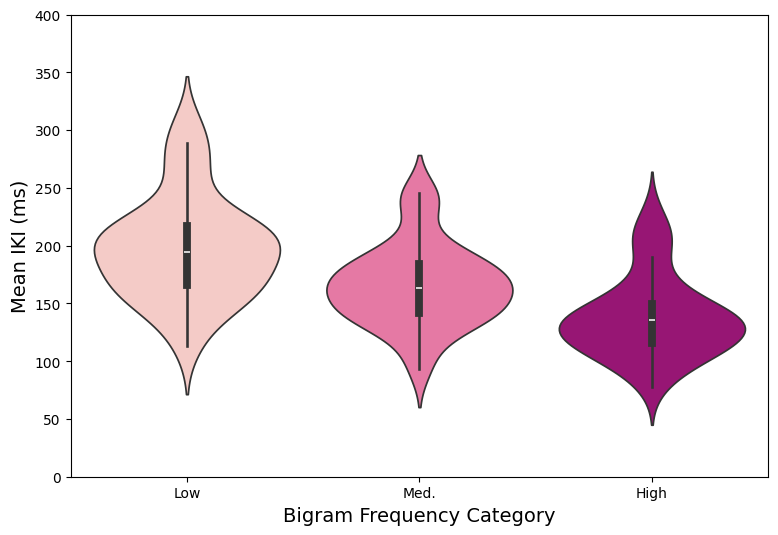

In [24]:
# Mean IKI | Bigram Freq. - white background
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bybf, 
    x="bf_type", 
    y="mean_IKI", 
    hue='bf_type', 
    palette='RdPu'
)

ax.set(
    xlabel='Bigram Frequency Category', 
    ylabel='Mean IKI (ms)',
    xticks=[0, 1, 2],
    xticklabels=['Low', 'Med.', 'High'],
    ylim=[0, 400]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.savefig(save_dir + 'violin_meanikis_bf.png', dpi=300)
plt.show()

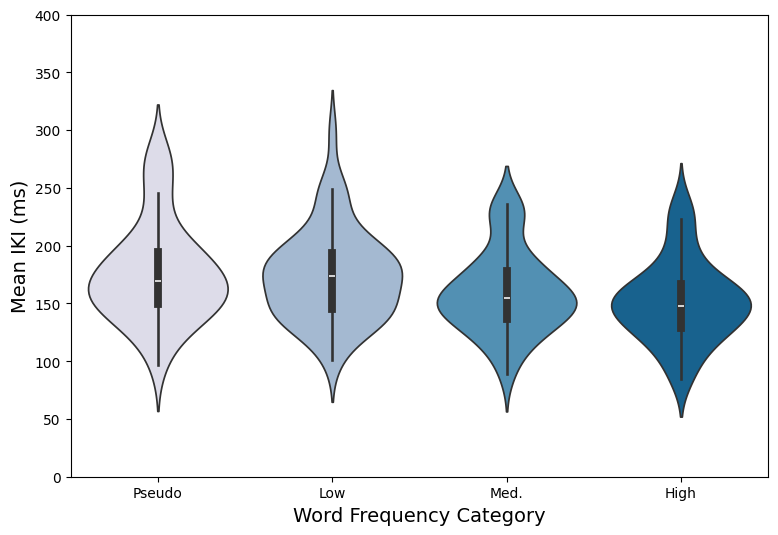

In [25]:
# Mean IKI | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bywf, 
    x="wf_type", 
    y="mean_IKI", 
    hue='wf_type', 
    palette='PuBu'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='Mean IKI (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 400]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_meanikis_wf.png', dpi=300)
plt.show()

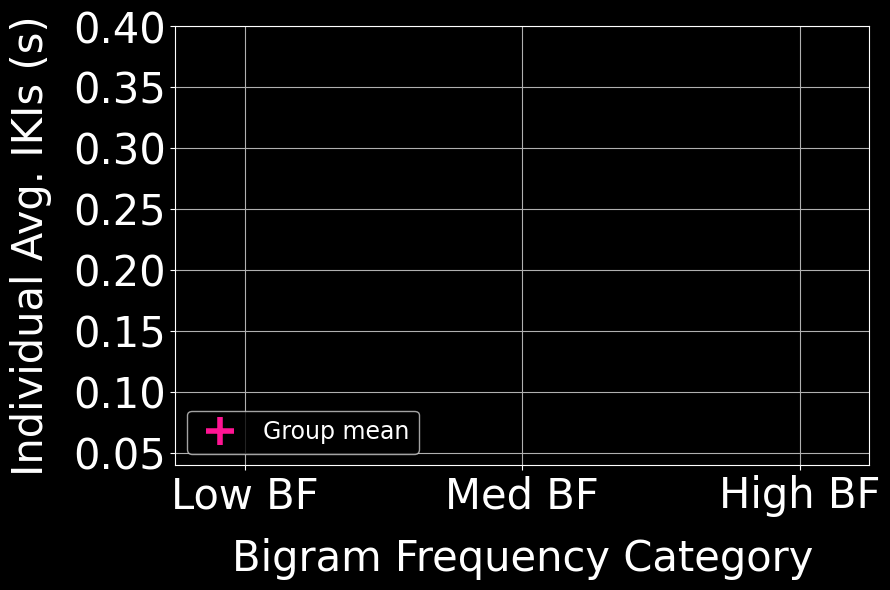

In [26]:
## individual IKI means by BF (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (all_bybf[all_bybf['bf_type'] == 'low']['mean_IKI'], 
     all_bybf[all_bybf['bf_type'] == 'med']['mean_IKI'],
     all_bybf[all_bybf['bf_type'] == 'high']['mean_IKI'])
means = (np.mean(all_bybf[all_bybf['bf_type'] == 'low']['mean_IKI']),
         np.mean(all_bybf[all_bybf['bf_type'] == 'med']['mean_IKI']),
         np.mean(all_bybf[all_bybf['bf_type'] == 'high']['mean_IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.xlim([1.5, 6.5])
plt.ylim([0.04, 0.4])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15, size=30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'mean_ikis_corr_TESTWITHINDIVMEANS.png', dpi=300)
plt.show()

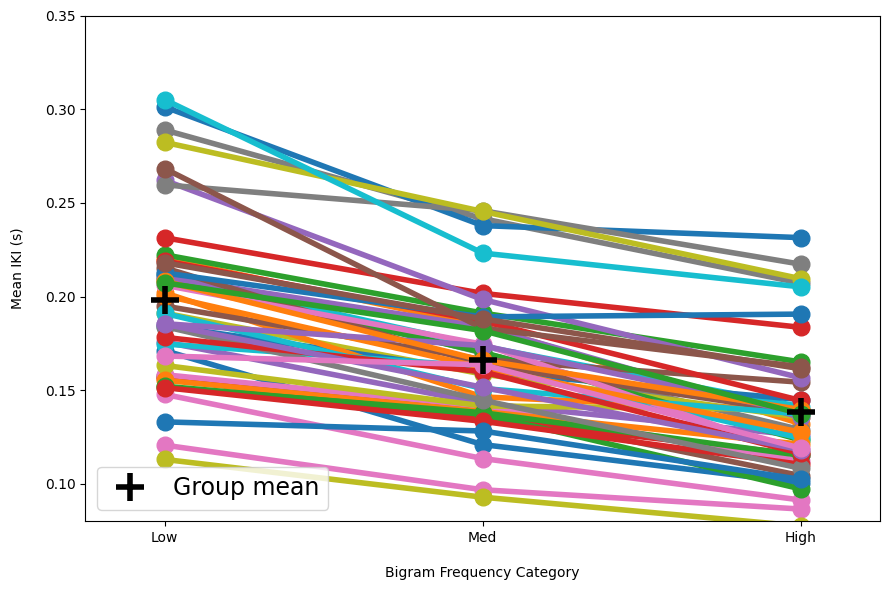

In [27]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI'],
     indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI'])
means = (np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.35])
plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

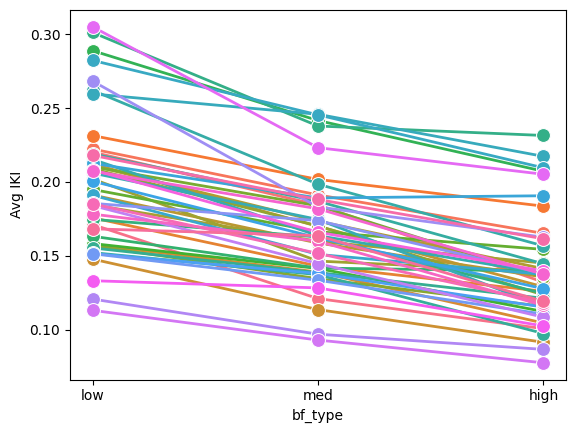

In [28]:
## seaborn version of individuals plot
data = pd.concat([indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf'),
                  indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf'),
                  indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')])

ax = sns.lineplot(data=data, x='bf_type', y='Avg IKI', hue='sID', marker = 'o', markersize = 10, linewidth = 2)
ax.get_legend().set_visible(False)
plt.show()

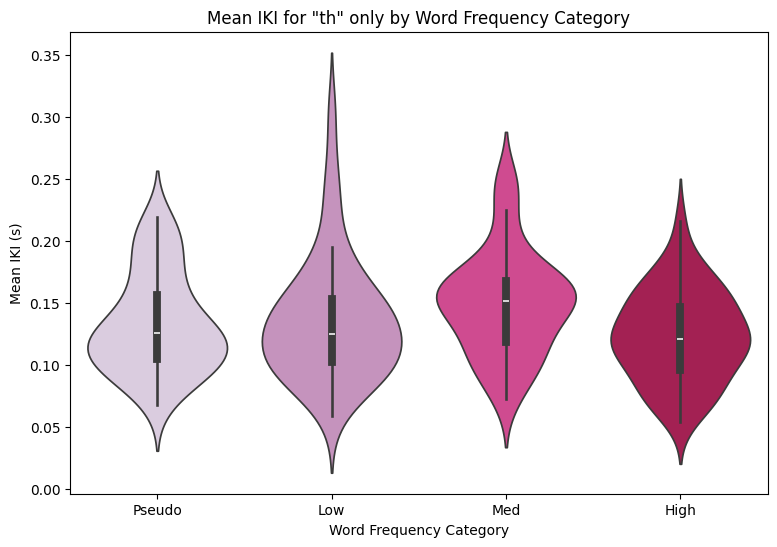

In [29]:
## Mean IKI for 'th' across WF (correct trials only)
# sns.set_style("ticks", rc=custom)
# sns.set_context('talk')
# plt.style.use("dark_background")

th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'he']

data = {'Pseudo' : indiv_meanikis(th_df, 'string', 'pseudo')['Avg IKI'],
        'Low': indiv_meanikis(th_df, 'string', 'lowwf')['Avg IKI'], 
        'Med': indiv_meanikis(th_df, 'string', 'medwf')['Avg IKI'],
        'High': indiv_meanikis(th_df, 'string', 'highwf')['Avg IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean IKI (s)')
ax.set(xlabel='Word Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig(save_dir + 'violin_meanikis_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

<Figure size 640x480 with 0 Axes>

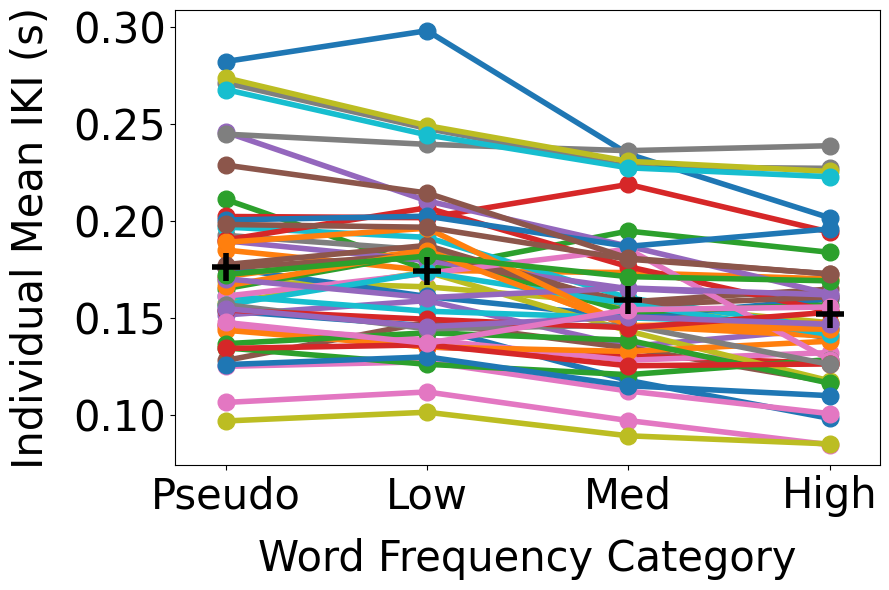

In [30]:
## individual IKI means by WF category
plt.rcParams.update(plt.rcParamsDefault)
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI'],
    indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI'])

means = (np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI']), 
         np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI']), 
         np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI']),
        np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Individual Mean IKI (s)", labelpad=15, fontsize = 30)
plt.title("")
# plt.legend(loc="best")

fig.tight_layout()
# plt.savefig(save_dir + 'indiv_mean_ikis.png', dpi=300)
plt.show()

In [31]:
np.sqrt(len(corr_trials_bybg.IKI))

np.float64(204.35508312738395)

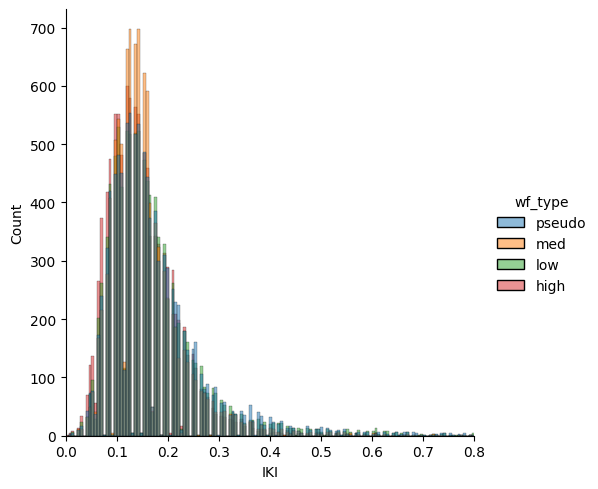

In [32]:
## histograms of mean IKI by WF
# sns.set(rc={"figure.figsize":(9, 6)})
sns.displot(corr_trials_bybg, x='IKI', hue='wf_type', bins=177)
plt.xlim(0, 0.8)
plt.show()

# SD IKI
___

## SD IKI Statistics

In [33]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | bigram frequency
print(pg.rm_anova(all_bybf, 'sd_IKI', 'bf_type', 'sID'))
pg.pairwise_tukey(all_bybf, 'sd_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc     p-GG-corr      ng2  \
0  bf_type      2     92  144.276764  4.316338e-29  5.050472e-26  0.33047   

        eps  sphericity   W-spher   p-spher  
0  0.884537       False  0.869465  0.042971  


A    B     mean(A)     mean(B)       diff        se         T  \
0  high  low   60.370555  104.963008 -44.592454  5.565082 -8.012901   
1  high  med   60.370555   73.139232 -12.768677  5.565082 -2.294427   
2   low  med  104.963008   73.139232  31.823777  5.565082  5.718474   

        p-tukey     cohen  
0  1.308287e-12 -1.591271  
1  5.991374e-02 -0.531882  
2  1.910480e-07  1.110130

In [34]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'sd_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'sd_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2           F         p-unc       ng2      eps
0  avgbf_type      2     92  135.223688  4.064171e-28  0.307098  0.89675


A    B     mean(A)     mean(B)       diff        se        T  \
0  high  low   60.718985  101.712750 -40.993766  5.454657 -7.51537   
1  high  med   60.718985   70.994742 -10.275757  5.454657 -1.88385   
2   low  med  101.712750   70.994742  30.718008  5.454657  5.63152   

        p-tukey     cohen  
0  1.947642e-11 -1.489093  
1  1.472047e-01 -0.441428  
2  2.882712e-07  1.087505

In [35]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | word frequency
print(pg.rm_anova(all_bywf, 'sd_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'sd_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    138  42.736919  1.348870e-19  0.203447  0.900951


A       B    mean(A)    mean(B)       diff       se         T  \
0  high     low  63.555058  96.563214 -33.008156  5.83601 -5.655945   
1  high     med  63.555058  70.640590  -7.085532  5.83601 -1.214105   
2  high  pseudo  63.555058  93.101850 -29.546792  5.83601 -5.062841   
3   low     med  96.563214  70.640590  25.922624  5.83601  4.441840   
4   low  pseudo  96.563214  93.101850   3.461364  5.83601  0.593105   
5   med  pseudo  70.640590  93.101850 -22.461260  5.83601 -3.848735   

        p-tukey     cohen  
0  3.489389e-07 -1.274729  
1  6.186961e-01 -0.288004  
2  5.925440e-06 -1.086481  
3  9.007385e-05  0.883334  
4  9.340635e-01  0.109705  
5  9.344703e-04 -0.736430

## SD IKI Figures

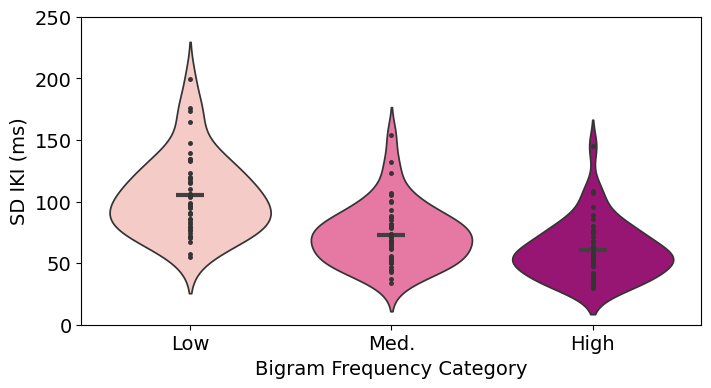

In [36]:
# SD IKI | Bigram Freq. - white background
# edited for TL1 grant
fig, ax = plt.subplots(figsize=(8,4))

sns.violinplot(
    data=all_bybf, 
    x="bf_type", 
    y="sd_IKI", 
    hue='bf_type', 
    palette='RdPu',
    inner='point',
)

categories = ['low', 'med', 'high']
violin_means = all_bybf.groupby(['bf_type']).sd_IKI.agg('mean').reset_index()
violin_means['bf_type'] = pd.Categorical(violin_means['bf_type'],
                                              categories=categories,
                                              ordered=True)                          
violin_means = violin_means.sort_values(by="bf_type")

sns.scatterplot(x=range(len(violin_means['sd_IKI'])), y=violin_means['sd_IKI'], 
                    color='0.25', ax=ax,
                    marker='_', linewidth=3, s=400)

ax.set(
    xlabel='Bigram Frequency Category', 
    ylabel='SD IKI (ms)',
    xticks=[0, 1, 2],
    xticklabels=['Low', 'Med.', 'High'],
    ylim=[0, 250]
)

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig(save_dir + 'violin_sdiki_bf_TL1.png', dpi=300, bbox_inches="tight")
plt.show()

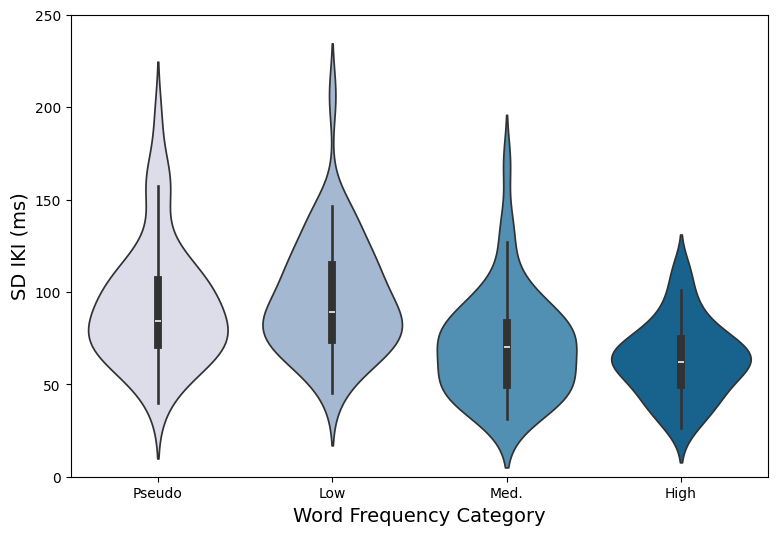

In [37]:
# SD IKI | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bywf, 
    x="wf_type", 
    y="sd_IKI", 
    hue='wf_type', 
    palette='PuBu'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='SD IKI (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 250]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_sdiki_wf.png', dpi=300)
plt.show()

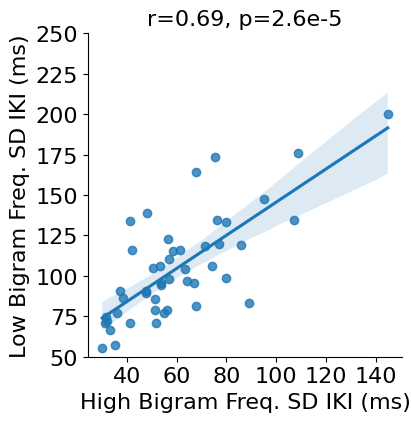

In [38]:
## Correlation between low and high BF SD IKIs across individuals 
low_sds = all_bybf[all_bybf['bf_type'] == 'low']
low_sds = low_sds[['sID', 'sd_IKI']].copy()
high_sds = all_bybf[all_bybf['bf_type'] == 'high']['sd_IKI'].reset_index(drop=True)

d = {'sID': low_sds['sID'], 'high_sd': high_sds, 'low_sd': low_sds['sd_IKI']}
sd_lmdata = pd.DataFrame(data=d)


g = sns.lmplot(x="high_sd", y="low_sd", data=sd_lmdata, height=4)
g.set_axis_labels("High Bigram Freq. SD IKI (ms)", 
                  "Low Bigram Freq. SD IKI (ms)", 
                  fontsize = 16)

g.ax.set_title('r=0.69, p=2.6e-5', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(50, 250)

plt.savefig(save_dir + 'highvlow_sd_TL1.png', dpi=300, bbox_inches="tight")
plt.show()

In [39]:
# ## individual MEAN SD IKI by BF (correct trials)
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6]
# D = (indiv_sdikis(tight_bgs, 'bigram', 'lowbf_norep')['Avg SD IKI'], 
#      indiv_sdikis(tight_bgs, 'bigram', 'medbf_norep')['Avg SD IKI'],
#      indiv_sdikis(tight_bgs, 'bigram', 'highbf')['Avg SD IKI'])
# means = (np.mean(indiv_sdikis(tight_bgs, 'bigram', 'lowbf_norep')['Avg SD IKI']), 
#          np.mean(indiv_sdikis(tight_bgs, 'bigram', 'medbf_norep')['Avg SD IKI']),
#          np.mean(indiv_sdikis(tight_bgs, 'bigram', 'highbf')['Avg SD IKI']))

# fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')
# ax.set_facecolor('black')

# # cm = plt.get_cmap('tab20')
# # for index, data in enumerate(ID_list):
# #     if index == len(ID_list)-1:
# #         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
# #     else:
# #         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

# ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.01, 0.07])
# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
# plt.yticks(size = 30)
# plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
# plt.ylabel("Indiv. Avg. SD IKI (s)", labelpad=15, size=30)
# plt.grid(visible=None)

# plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# plt.savefig(save_dir + 'meansds_bybf_corr.png', dpi=300, transparent = True)
# plt.show()

In [40]:
# ## mean CV IKI for 'th' by WF (correct trials only)
# th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 're']

# data = {'Pseudo' : indiv_sdikis(th_df, 'string', 'pseudo')['Avg SD IKI'], 
#         'Low': indiv_sdikis(th_df, 'string', 'lowwf')['Avg SD IKI'], 
#         'Med' : indiv_sdikis(th_df, 'string', 'medwf')['Avg SD IKI'],
#         'High' : indiv_sdikis(th_df, 'string', 'highwf')['Avg SD IKI']}
# DF = pd.DataFrame(data)

# # sns.set(rc={"figure.figsize":(9, 6)})
# fig, ax = plt.subplots(figsize=(9,6))
# # sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='PuRd', ax=ax)
# ax.set(title = 'Mean SD IKI for "th" only by Word Frequency Category')
# ax.set(ylabel='Mean SD IKI (s)')
# ax.set(xlabel='Word Frequency Category')
# # ax.set_ylim(-0.02, 0.30)

# plt.savefig(save_dir + 'violin_meansds_thbywf_corr.png', dpi=300)
# plt.show()

# CV IKI
___

## CV IKI Statistics

In [41]:
# Runs one-way, repeated measures ANOVA:
# individual CV IKI | bigram frequency
print(pg.rm_anova(all_bybf, 'cv_IKI', 'bf_type', 'sID'))
pg.pairwise_tukey(all_bybf, 'cv_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     92  34.515539  6.552300e-12  0.166066  0.890593


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.434297  0.526126 -0.091830  0.020033 -4.583812  0.000030   
1  high  med  0.434297  0.436083 -0.001787  0.020033 -0.089181  0.995625   
2   low  med  0.526126  0.436083  0.090043  0.020033  4.494630  0.000043   

      cohen  
0 -0.927445  
1 -0.017674  
2  0.990009

In [42]:
# Runs one-way, repeated measures ANOVA:
# individual mean CV | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'cv_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'cv_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2          F         p-unc       ng2       eps
0  avgbf_type      2     92  17.613832  3.338017e-07  0.088943  0.945653


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.429556  0.501916 -0.072359  0.020198 -3.582482  0.001360   
1  high  med  0.429556  0.451762 -0.022206  0.020198 -1.099388  0.516076   
2   low  med  0.501916  0.451762  0.050154  0.020198  2.483095  0.037606   

      cohen  
0 -0.752054  
1 -0.217699  
2  0.525763

In [43]:
## anova for cvs (by word freq)
print(pg.rm_anova(all_bywf, 'cv_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'cv_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    138  33.833915  1.867786e-16  0.237522  0.910861


A       B   mean(A)   mean(B)      diff        se         T  \
0  high     low  0.415174  0.551158 -0.135984  0.021347 -6.370092   
1  high     med  0.415174  0.434850 -0.019676  0.021347 -0.921713   
2  high  pseudo  0.415174  0.521931 -0.106757  0.021347 -5.000973   
3   low     med  0.551158  0.434850  0.116308  0.021347  5.448379   
4   low  pseudo  0.551158  0.521931  0.029227  0.021347  1.369119   
5   med  pseudo  0.434850  0.521931 -0.087081  0.021347 -4.079260   

        p-tukey     cohen  
0  8.817888e-09 -1.391968  
1  7.932752e-01 -0.189248  
2  7.861774e-06 -1.139479  
3  9.633049e-07  1.034494  
4  5.203270e-01  0.283764  
5  3.886563e-04 -0.799129

## CV IKI Figures

In [44]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_cvikis(all_bigrams, 'bigram', 'highbf'),
    indiv_cvikis(all_bigrams, 'bigram', 'medbf').rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_cvikis(all_bigrams, 'bigram', 'lowbf').rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})
# cv_df

In [45]:
all_bybf.groupby('bf_type').cv_IKI.agg('std')

bf_type
high    0.108397
low     0.088642
med     0.093204
Name: cv_IKI, dtype: float64

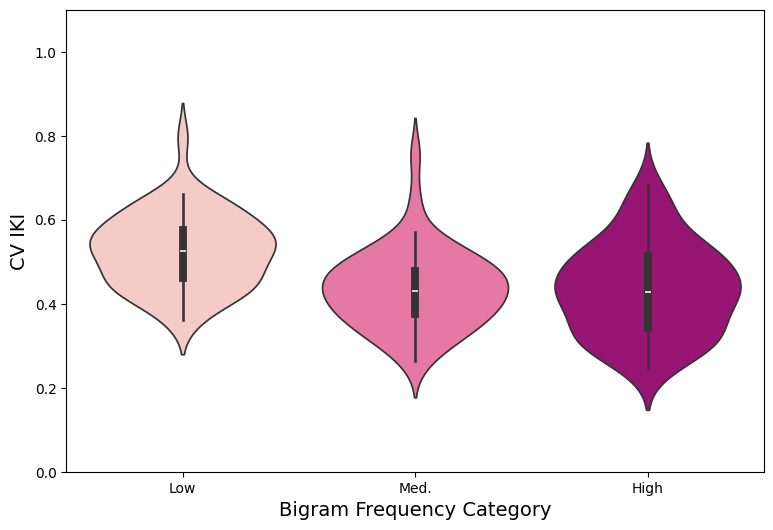

In [46]:
# CV IKI | Bigram Freq. - white background
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bybf, 
    x="bf_type", 
    y="cv_IKI", 
    hue='bf_type', 
    palette='RdPu',
)

ax.set(
    xlabel='Bigram Frequency Category', 
    ylabel='CV IKI',
    xticks=[0, 1, 2],
    xticklabels=['Low', 'Med.', 'High'],
    ylim=[0, 1.1]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_cviki_bf.png', dpi=300)
plt.show()

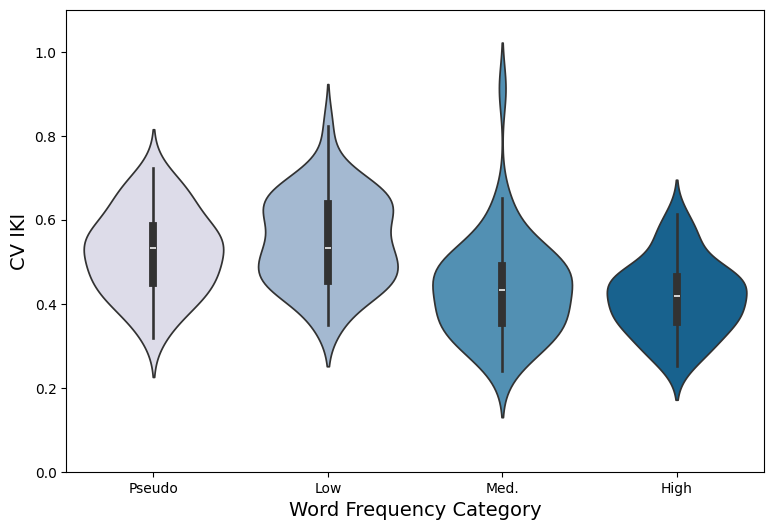

In [47]:
# CV IKI | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bywf, 
    x="wf_type", 
    y="cv_IKI", 
    hue='wf_type', 
    palette='PuBu',
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='CV IKI',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 1.1]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_cviki_wf.png', dpi=300)
plt.show()

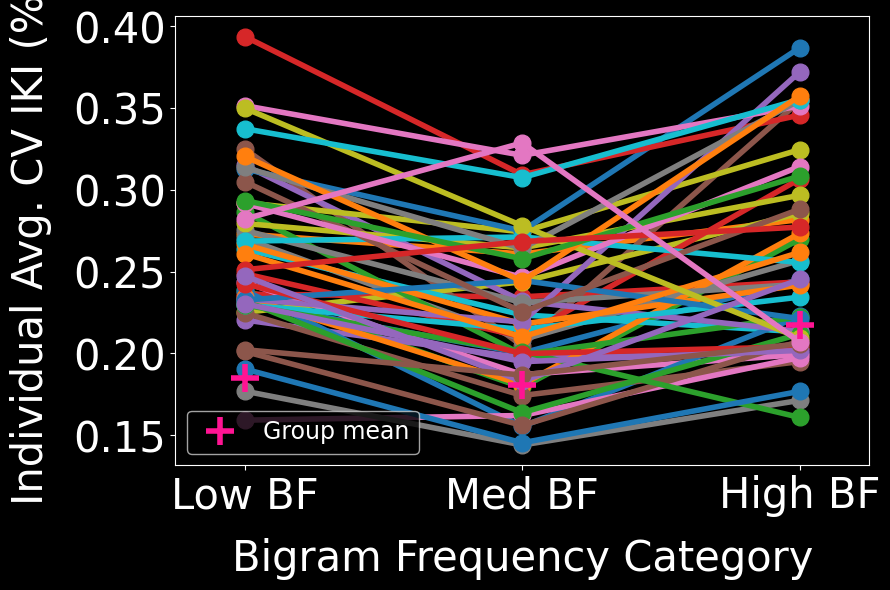

In [48]:
## Individual MEAN CV IKIs sorted by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(tight_bgs, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(tight_bgs, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(tight_bgs, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.1, 0.5])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size = 30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size = 30)
plt.yticks(size=30)
plt.ylabel("Individual Avg. CV IKI (%)", labelpad=15, size = 30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'cvikis_bybf_corr.png', dpi=300, transparent = True)
plt.show()

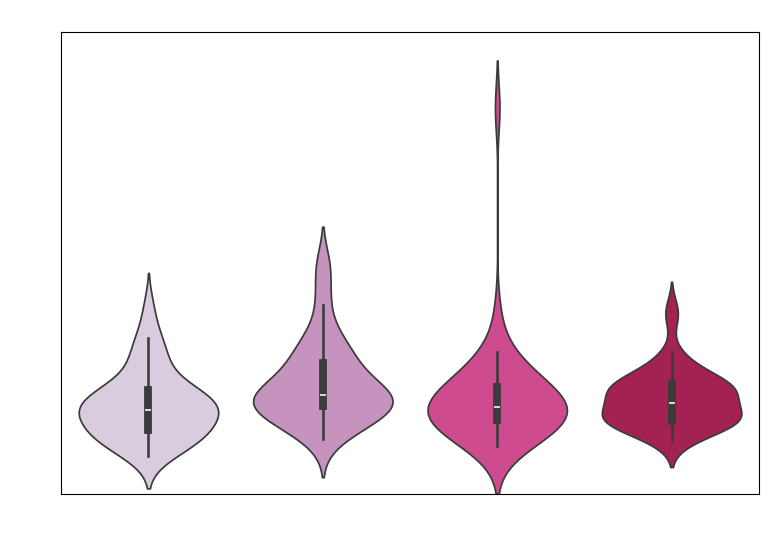

In [49]:
## Mean CV IKI for 'th' across WF (correct trials only)
th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'th']

data = {'Pseudo' : indiv_cvikis(th_df, 'string', 'pseudo')['Avg CV IKI'], 
        'Low': indiv_cvikis(th_df, 'string', 'lowwf')['Avg CV IKI'], 
        'Med' : indiv_cvikis(th_df, 'string', 'medwf')['Avg CV IKI'],
        'High' : indiv_cvikis(th_df, 'string', 'highwf')['Avg CV IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean CV IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean CV IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(-0.03, 1)

plt.savefig(save_dir + 'violin_meancvs_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

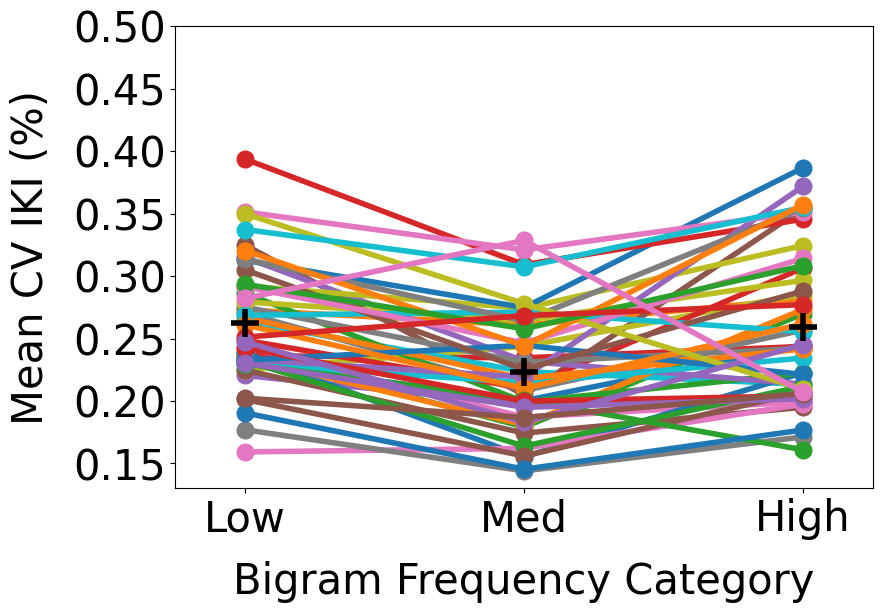

In [50]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
plt.xticks(x, ('Low', 'Med', 'High'), size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)

plt.yticks(size=30)
plt.ylabel("Mean CV IKI (%)", labelpad=15, size=30)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

# Mean, SD, & CV RT

______

## RT Statistics

In [51]:
# ## NOT RELEVANT FOR MANUSCRIPT ##

# ## finding indices of trials that occur after an error
# err_indices = list(all_trials[all_trials['trial_corr'] == 'incorr'].index.values)
# posterr_indices = list(map(lambda x: x + 1, err_indices))

# ## making dataframe of only post-error trial reaction times
# all_rts = corr_trials[['sID', 'key_resp.rt.1', 'wf_type']]
# posterr_rts = all_rts.filter(posterr_indices, axis=0)

# ## making dataframe of only post-success trial reaction times
# all_indices = list(all_trials.index.values)
# bad_indices = (err_indices + posterr_indices)
# postsucc_indices = list(filter(lambda x: x not in set(bad_indices), all_indices))
# postsucc_rts = all_rts.filter(postsucc_indices, axis=0)

In [52]:
# Creates dataframes of RT metric values for average bigram and word frequencies.
rt_byavgbf = indiv_rtmetric(corr_trials, avgbf_groups, iki_metrics)
rt_bywf = indiv_rtmetric(corr_trials, wf_groups, iki_metrics)

In [53]:
# Runs one-way, repeated measures ANOVA:
# individual mean RT | word frequency
print(pg.rm_anova(rt_bywf, 'mean_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(rt_bywf, 'mean_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc     p-GG-corr       ng2  \
0  wf_type      3    138  135.608178  5.778300e-41  4.334500e-27  0.127454   

       eps  sphericity   W-spher   p-spher  
0  0.63884       False  0.452539  0.000001  


A       B     mean(A)     mean(B)        diff         se         T  \
0  high     low  727.682761  787.782987  -60.100226  30.787949 -1.952070   
1  high     med  727.682761  760.487265  -32.804504  30.787949 -1.065498   
2  high  pseudo  727.682761  879.356285 -151.673524  30.787949 -4.926393   
3   low     med  787.782987  760.487265   27.295722  30.787949  0.886572   
4   low  pseudo  787.782987  879.356285  -91.573298  30.787949 -2.974323   
5   med  pseudo  760.487265  879.356285 -118.869020  30.787949 -3.860894   

    p-tukey     cohen  
0  0.210213 -0.427330  
1  0.710936 -0.246569  
2  0.000011 -0.950410  
3  0.811841  0.197593  
4  0.017387 -0.558847  
5  0.000893 -0.755258

In [54]:
# Runs one-way, repeated measures ANOVA:
# individual SD RT | word frequency
print(pg.rm_anova(rt_bywf, 'sd_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(rt_bywf, 'sd_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    138  19.987303  8.116562e-11  0.116395  0.862362


A       B     mean(A)     mean(B)       diff         se         T  \
0  high     low  121.133954  137.583671 -16.449716  11.727534 -1.402658   
1  high     med  121.133954  133.518948 -12.384993  11.727534 -1.056061   
2  high  pseudo  121.133954  175.763073 -54.629119  11.727534 -4.658193   
3   low     med  137.583671  133.518948   4.064723  11.727534  0.346597   
4   low  pseudo  137.583671  175.763073 -38.179402  11.727534 -3.255535   
5   med  pseudo  133.518948  175.763073 -42.244125  11.727534 -3.602132   

    p-tukey     cohen  
0  0.499296 -0.293303  
1  0.716602 -0.229101  
2  0.000036 -0.960355  
3  0.985653  0.071539  
4  0.007307 -0.641533  
5  0.002278 -0.733303

In [55]:
# Runs one-way, repeated measures ANOVA:
# individual CV RT | word frequency
print(pg.rm_anova(rt_bywf, 'cv_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(rt_bywf, 'cv_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2         F    p-unc       ng2       eps
0  wf_type      3    138  6.150924  0.00059  0.061083  0.872554


A       B   mean(A)   mean(B)      diff       se         T   p-tukey  \
0  high     low  0.161257  0.169103 -0.007846  0.01099 -0.713957  0.891464   
1  high     med  0.161257  0.171077 -0.009819  0.01099 -0.893513  0.808230   
2  high  pseudo  0.161257  0.197010 -0.035752  0.01099 -3.253284  0.007360   
3   low     med  0.169103  0.171077 -0.001973  0.01099 -0.179556  0.997938   
4   low  pseudo  0.169103  0.197010 -0.027906  0.01099 -2.539327  0.057290   
5   med  pseudo  0.171077  0.197010 -0.025933  0.01099 -2.359771  0.088655   

      cohen  
0 -0.145785  
1 -0.182573  
2 -0.690167  
3 -0.036070  
4 -0.528925  
5 -0.491874

## RT Figures

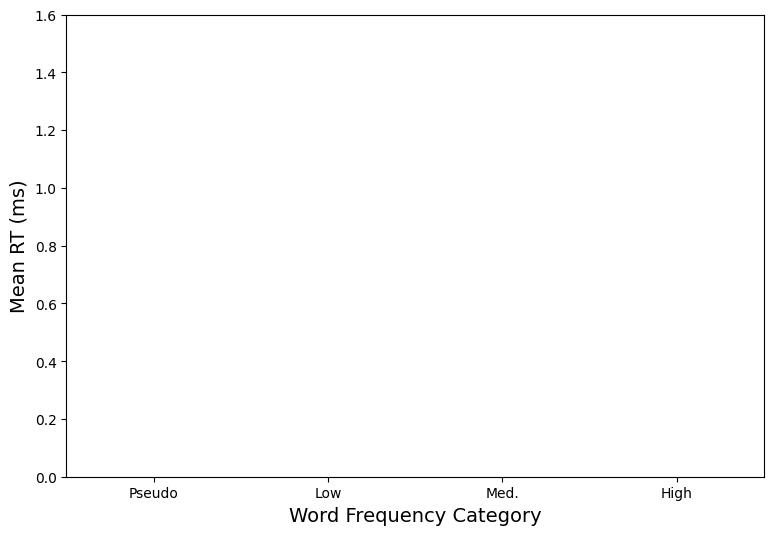

In [56]:
# Mean RT | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=rt_bywf, 
    x="wf_type", 
    y="mean_RT", 
    hue='wf_type', 
    palette='YlGn',
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='Mean RT (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 1.6]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_meanrt_wf.png', dpi=300)
plt.show()

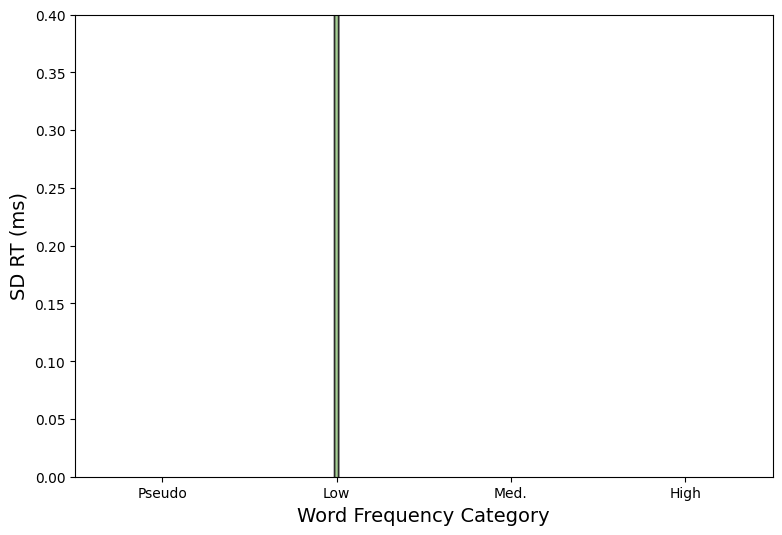

In [57]:
# SD RT | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=rt_bywf, 
    x="wf_type", 
    y="sd_RT", 
    hue='wf_type', 
    palette='YlGn',
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='SD RT (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 0.4]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_sdrt_wf.png', dpi=300)
plt.show()

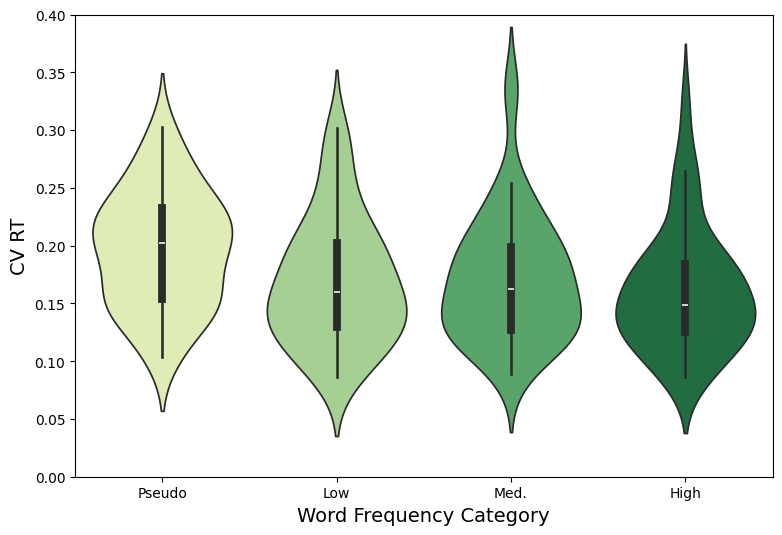

In [58]:
# CV RT | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=rt_bywf, 
    x="wf_type", 
    y="cv_RT", 
    hue='wf_type', 
    palette='YlGn',
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='CV RT',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 0.4]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.savefig(save_dir + 'violin_cvrt_wf.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

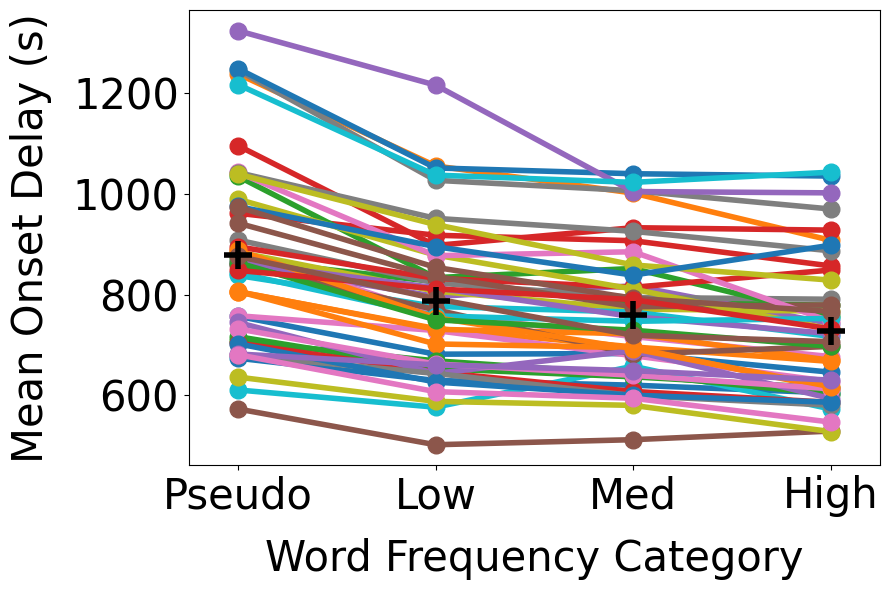

In [59]:
## plotting average onset delays by WF group
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (rt_bywf[rt_bywf['wf_type'] == 'pseudo']['mean_RT'],
    rt_bywf[rt_bywf['wf_type'] == 'low']['mean_RT'],
    rt_bywf[rt_bywf['wf_type'] == 'med']['mean_RT'],
    rt_bywf[rt_bywf['wf_type'] == 'high']['mean_RT'])

means = (np.mean(rt_bywf[rt_bywf['wf_type'] == 'pseudo']['mean_RT']),
        np.mean(rt_bywf[rt_bywf['wf_type'] == 'low']['mean_RT']),
        np.mean(rt_bywf[rt_bywf['wf_type'] == 'med']['mean_RT']),
        np.mean(rt_bywf[rt_bywf['wf_type'] == 'high']['mean_RT']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_bywf.png', dpi=300)
plt.show()

# Total Trial Error
___

## Total Trial Error Statistics

In [60]:
## anova for error rates (by bg freq)
all_errors_bybf = all_ikimetric(indiv_error, incorr_bgs, 
                                   'bigram', bf_groups)

total_bigrams = pd.DataFrame(all_bigrams.groupby(['sID', 
                                                  'bf_type']).size()).reset_index()
total_bigrams = total_bigrams.reset_index(drop=True).rename(columns={0:'bigrams'})

all_errors_bybf['relative_error'] = all_errors_bybf['total_error'] / total_bigrams['bigrams']

print(pg.rm_anova(all_errors_bybf, 'relative_error', 'bf_type', 'sID'))

# pg.pairwise_tukey(all_errors_bybf, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2       eps
0  bf_type      2     92  7.298871  0.001142  0.050591  0.816366


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


In [61]:
## anova for error rates (by avg bg freq)
all_errors_byavgbf = all_ikimetric(indiv_error, incorr_trials, 
                                   'string', avgbf_groups)

print(pg.rm_anova(all_errors_byavgbf, 'total_error', 'avgbf_type', 'sID'))

pg.pairwise_tukey(all_errors_byavgbf, 'total_error', 
                  'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc       ng2       eps
0  avgbf_type      2     92  9.329468  0.000205  0.070374  0.926751


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  4.319149  6.829787 -2.510638  0.781257 -3.213589  0.004623   
1  high  med  4.319149  5.340426 -1.021277  0.781257 -1.307223  0.393581   
2   low  med  6.829787  5.340426  1.489362  0.781257  1.906367  0.140711   

      cohen  
0 -0.670255  
1 -0.293654  
2  0.362245

In [62]:
## anova for error rates (by word freq)
all_errors_bywf = all_ikimetric(indiv_error, incorr_trials, 
                                'string', wf_groups)

total_trials = pd.DataFrame(all_trials.groupby(['sID', 'wf_type']).size()).reset_index()
total_trials = total_trials.reset_index(drop=True).rename(columns={0:'trials'})

all_errors_bywf['relative_error'] = all_errors_bywf['total_error'] / total_trials['trials']

print(pg.rm_anova(all_errors_bywf, 'total_error', 'wf_type', 'sID'))

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  wf_type      3    138  1.221777  0.304222   0.303265  0.011664  0.856119   

   sphericity   W-spher   p-spher  
0       False  0.752211  0.026037  


## Trial Error Figures

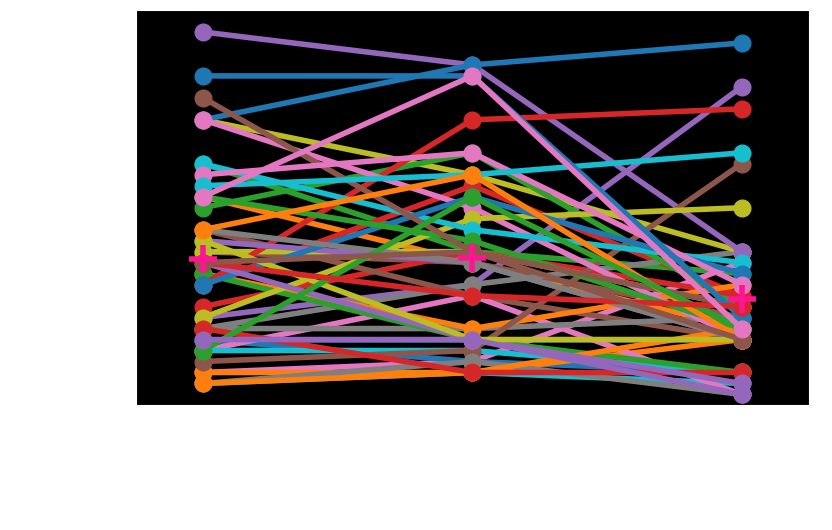

In [63]:
## Individual total trial error by bigram BF
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', 'lowbf')['total_error'], 
     indiv_error(incorr_bgs, 'bigram', 'medbf')['total_error'],
     indiv_error(incorr_bgs, 'bigram', 'highbf')['total_error'])

means = (np.mean(indiv_error(incorr_bgs, 'bigram', 'lowbf')['total_error']), 
         np.mean(indiv_error(incorr_bgs, 'bigram', 'medbf')['total_error']),
         np.mean(indiv_error(incorr_bgs, 'bigram', 'highbf')['total_error']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([-1, 35])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'meanerr_bybf.png', dpi=300)
plt.show()

In [64]:
## Individual total trial error by AVG BF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6]
# D = (indiv_error(incorr_trials, 'string', 'avg_lowbf')['Total Error'], 
#      indiv_error(incorr_trials, 'string', 'avg_medbf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'avg_highbf')['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# plt.savefig(save_dir + 'indiv_sdikis.png', dpi=300)
# plt.show()

In [65]:
## Individual total trial error by WF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6, 8]

# D = (indiv_error(incorr_trials, 'string', 'pseudo')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'lowwf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'medwf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'highwf')['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# print([len(x) for x in D])
# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 8.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
# plt.xlabel("Word Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig(save_dir + 'indiv_sdikis.png', dpi=300)
# plt.show()

# Delta RT

In [66]:
# Calculates the change in reaction time (delta RT) across consecutive 
# repetitions of the same string.
def deltart(dataframe):
    deltarts = pd.DataFrame(dataframe.groupby(['sID', 
                                               'string']).RT.agg(['diff']))
    return deltarts

# Adding 'delta_rt' column to corr_trials dataframe.
corr_trials = corr_trials.assign(delta_rt=deltart(corr_trials))

# Averages delta RTs across frequency groups for each subject and puts into 
# one dataframe.
def indiv_deltart(dataframe, typ_group_list):
    all_deltarts = pd.DataFrame()
    for typ_group in typ_group_list:
        group = getattr(typ, typ_group)
        DF = dataframe[dataframe.string.isin(group)]
        delta_DF = pd.DataFrame(DF)
        delta_DF['delta_rt'] = deltart(DF)
        delta_DF = delta_DF[delta_DF['rep_num'] != 0]
        mean_byindiv = delta_DF.groupby(['sID']).delta_rt.agg(['mean'])
        # mean_byindiv = pd.DataFrame(delta_DF.groupby('sID').agg('mean'))
        mean_deltarts = mean_byindiv.rename(columns={'mean' : 'mean_deltart'}).reset_index()
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            mean_deltarts['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            mean_deltarts['wf_type'] = freq_type
        all_deltarts = pd.concat([all_deltarts, mean_deltarts])
    return all_deltarts

## Delta RT Statistics

In [67]:
## anova on delta reaction time across avg BF
all_deltarts_byavgbf = indiv_deltart(corr_trials, avgbf_groups)
# all_deltarts_byavgbf['mean_deltart'] = all_deltarts_byavgbf['mean_deltart']*1000

print(pg.rm_anova(all_deltarts_byavgbf, 'mean_deltart', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_deltarts_byavgbf, 'mean_deltart', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc       ng2      eps
0  avgbf_type      2     92  0.040695  0.960139  0.000286  0.96927


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low -0.013360 -0.013421  0.000061  0.002303  0.026341  0.999618   
1  high  med -0.013360 -0.013783  0.000423  0.002303  0.183664  0.981578   
2   low  med -0.013421 -0.013783  0.000362  0.002303  0.157323  0.986449   

      cohen  
0  0.005119  
1  0.038527  
2  0.034089

In [68]:
## anova on delta reaction time across WF
all_deltarts_bywf = indiv_deltart(corr_trials, wf_groups)
# all_deltarts_bywf['mean_deltart'] = all_deltarts_bywf['mean_deltart']*1000

print(pg.rm_anova(all_deltarts_bywf, 'mean_deltart', 'wf_type', 'sID'))
pg.pairwise_tukey(all_deltarts_bywf, 'mean_deltart', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2      eps
0  wf_type      3    138  14.696682  2.331149e-08  0.140031  0.89186


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.007839 -0.015659  0.007821  0.002743  2.851478  0.024809   
1  high     med -0.007839 -0.009626  0.001788  0.002743  0.651804  0.914809   
2  high  pseudo -0.007839 -0.021311  0.013473  0.002743  4.912231  0.000012   
3   low     med -0.015659 -0.009626 -0.006033  0.002743 -2.199675  0.127153   
4   low  pseudo -0.015659 -0.021311  0.005652  0.002743  2.060752  0.170004   
5   med  pseudo -0.009626 -0.021311  0.011685  0.002743  4.260427  0.000190   

      cohen  
0  0.615972  
1  0.150181  
2  0.925832  
3 -0.506657  
4  0.388315  
5  0.842531

## Delta RT Figures

<Figure size 640x480 with 0 Axes>

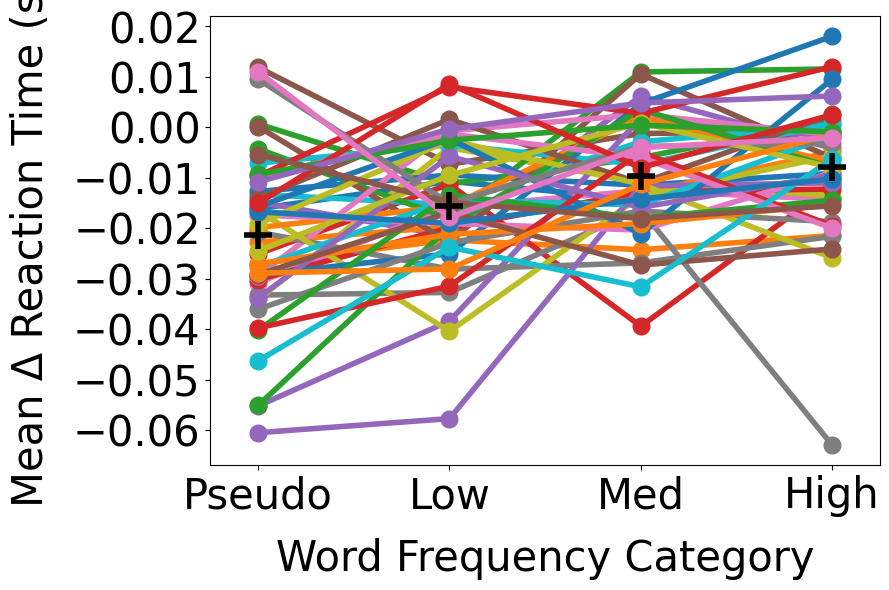

In [69]:
## plotting mean delta onset delays across WF
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')
# plt.rcParams['font.size'] = '30']

x = [2, 4, 6, 8]
D = (all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'pseudo']['mean_deltart'],
    all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'low']['mean_deltart'],
    all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'med']['mean_deltart'],
    all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'high']['mean_deltart'])

means = (np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'pseudo']['mean_deltart']),
        np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'low']['mean_deltart']),
        np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'med']['mean_deltart']),
        np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'high']['mean_deltart']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Mean Δ Reaction Time (s)", labelpad=15, fontsize = 30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaRT_bywf.png', dpi=300)
plt.show()

In [70]:
pseudo_only = corr_trials[corr_trials['wf_type'] == 'pseudo']
pseudo_rts = pseudo_only.groupby(['sID', 'rep_num']).RT.agg(['mean']).reset_index()

<Figure size 640x480 with 0 Axes>

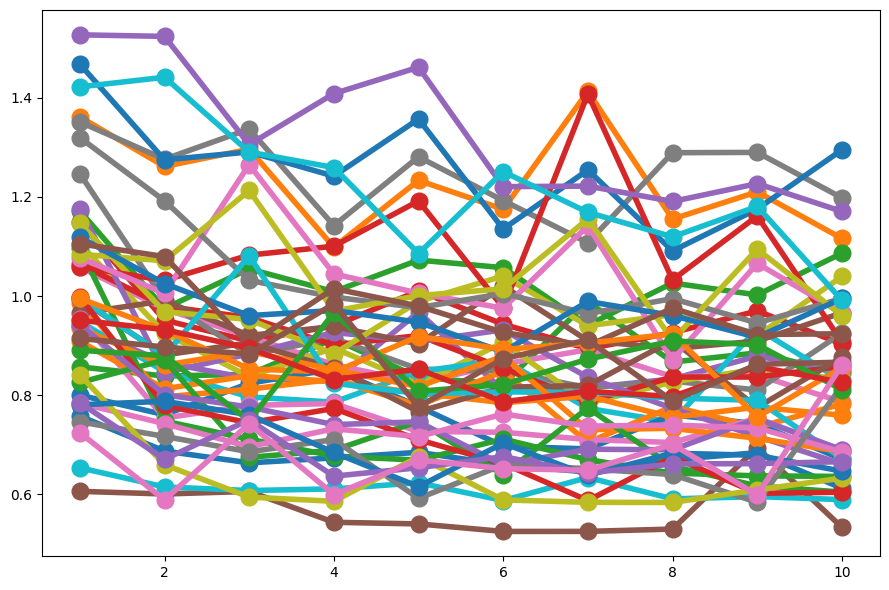

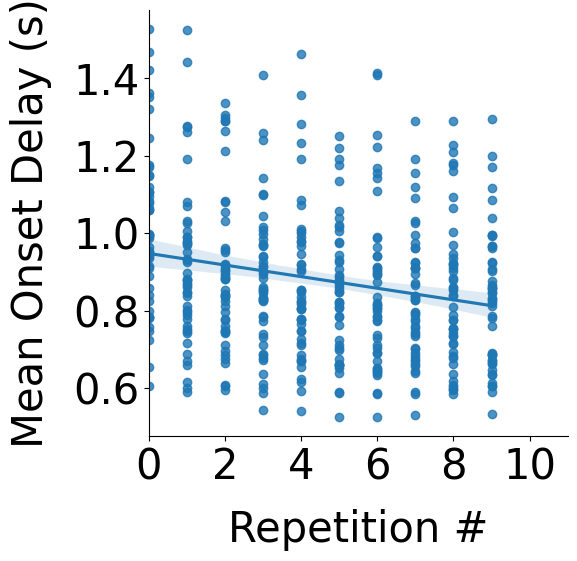

In [71]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_rts[pseudo_rts['rep_num'] == 0]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 1]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 2]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 3]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 4]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 5]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 6]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 7]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 8]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 9]['mean'])

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
sns.lmplot(x="rep_num", y="mean", data=pseudo_rts)

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_byrep.png', dpi=300)
plt.show()

In [72]:
## pearson correlation for 
print(pearsonr(pseudo_rts['mean'], pseudo_rts['rep_num']))

PearsonRResult(statistic=np.float64(-0.21843317672587187), pvalue=np.float64(1.7463417488590226e-06))


## High WF RTs vs. Simulated Null

In [73]:
# Randomly shuffles the RT/IKI values for high freq. bigrams/words for a 
# given participant and calculates the mean delta RT/IKI of each random 
# reshuffle.

def null_deltas(dataframe, metric_column):
    rep_num = 500
    shuff_means = []
    for n in range(0, rep_num):
        for ID in ID_list:
            if 'RT' in metric_column:
                shuff = dataframe[(dataframe['wf_type'] == 'highwf') & 
                                  (dataframe['sID'] == ID)]
                shuff = pd.DataFrame(shuff)
                shuff_vals = np.random.permutation(shuff[metric_column])
                shuff[metric_column] = shuff_vals
                shuff_deltas = deltart(shuff)
                shuff['delta_rt'] = shuff_deltas
                shuff_mean = np.mean(shuff['delta_rt'])
                shuff_means.append([n, ID, shuff_mean])
            if 'IKI' in metric_column:
                for bg_word in ['bf_type', 'wf_type']:
                    shuff = dataframe[(dataframe[bg_word] == 'high') & 
                                      (dataframe['sID'] == ID)]
                    shuff = pd.DataFrame(shuff)
                    shuff_vals = np.random.permutation(shuff[metric_column])
                    shuff[metric_column] = shuff_vals
                    shuff_deltas = deltaiki(shuff)
                    shuff['delta_iki'] = shuff_deltas
                    shuff_mean = np.mean(shuff['delta_iki'])
                    shuff_means.append([n, ID, bg_word, shuff_mean])
    shuff_means = pd.DataFrame(shuff_means)
    # shuff_means.to_csv(save_dir + '/shuff_means_ADDDATEHERE.csv')
    return shuff_means

In [74]:
# # Calcuating mean and STD delta IKI of high freq. bigrams
# highrt_df = all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'high']
# highrt_mean = highrt_df.mean_deltart.mean()
# highrt_std = highrt_df.mean_deltart.std()

# # Creating dataframe of mean delta RTs calculated from shuffled High WF 
# # datasets 
# shuff_rt = null_deltas(corr_trials, 'RT')

# # Saving dataset to report
# # shuff_rt.to_csv(save_dir + '/shuff_highrt_DDMMYYYY.csv')

# # Printing relevant information
# print('Mean delta RT of collected high freq. words', 
#       highrt_mean,
#       '±',
#       highrt_std)

# print('Average of shuffled mean delta RTs', 
#       np.mean(shuff_rt[2]),
#       '±',
#       np.std(shuff_rt[2]))

# p_val = np.mean(abs(shuff_rt[2]) > abs(highrt_mean))
# print('estimated p-val:', p_val)

# # Plotting mean delta RTs of shuffled data and observed value for high freq.
# # words.
# plt.hist(shuff_rt[2], bins=20)
# plt.axvline(x=highrt_mean, color='red', linestyle='--')

# plt.xlabel("Mean delta IKI")
# plt.title("")

# plt.show()

# Delta IKI

In [75]:
# Defining function that calcuates delta IKI from a given dataframe.
def deltaiki(dataframe):
    deltaikis = pd.DataFrame(dataframe.groupby(['sID', 
                                                'string', 
                                                'bigram']).IKI.agg(['diff']))
    # deltaikis.fillna(0, inplace=True)
    return deltaikis

# Adding delta IKI column to corr_trials_bybg dataframe.
corr_trials_bybg = corr_trials_bybg.assign(delta_iki=deltaiki(corr_trials_bybg))

# 
def indiv_meandeltaiki(dataframe, str_or_bg, typ_group_list):
    all_means = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        delta_DF = pd.DataFrame(DF)
        delta_DF['delta_iki'] = deltaiki(DF)
        delta_DF = delta_DF[delta_DF['rep_num'] != 0]
        deltas = delta_DF.groupby(['sID', 
                                   'string', 
                                   'bigram']).delta_iki.agg(['mean']).reset_index()
        deltas = deltas.rename(columns={'mean' : 'mean_deltaiki'})
        mean_deltaikis = deltas.groupby('sID').mean_deltaiki.agg(['mean']).reset_index()
        mean_deltaikis = mean_deltaikis.rename(columns={'mean' : 'mean_deltaiki'})
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                mean_deltaikis['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                mean_deltaikis['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             mean_deltaikis['bf_type'] = freq_type
        all_means = pd.concat([all_means, mean_deltaikis])
    all_means = all_means.rename(columns = {'mean': 'mean_IKI',
                                                'stdev': 'sd_IKI',
                                                'variation': 'cv_IKI'})
    return all_means.reset_index()

In [76]:
corr_trials_bybg

sID  bigram_num  trial_num  rep_num  bigram_loc bigram resp_bigram  \
0      s009           0          0        0           0     zi          zi   
1      s009           1          0        0           1     ib          ib   
2      s009           2          0        0           2     bj          bj   
3      s009           3          0        0           3     ja          ja   
4      s009           4          1        0           0     ch          ch   
...     ...         ...        ...      ...         ...    ...         ...   
32757  s352         959        238        9           3     ja          ja   
32758  s352         960        239        9           0     ch          ch   
32759  s352         961        239        9           1     ha          ha   
32760  s352         962        239        9           2     am          am   
32761  s352         963        239        9           3     mp          mp   

            IKI string resp_string    bg_freq bf_type meanbf_type wf_type  \
0      0.207861  zibja       zibja    54565.0     low         low  pseudo   
1      0.175981  zibja       zibja   493267.0     low         low  pseudo   
2      0.360005  zibja       zibja   105433.0     low         low  pseudo   
3      0.103974  zibja       zibja    40073.0     low         low  pseudo   
4      0.088020  cheer       cheer  3267507.0     med        high     med   
...         ...    ...         ...        ...     ...         ...     ...   
32757  0.111903  zibja       zibja    40073.0     low         low  pseudo   
32758  0.128008  champ       champ  3267507.0     med         med     med   
32759  0.127948  champ       champ  6967591.0    high         med     med   
32760  0.127979  champ       champ  1610395.0     med         med     med   
32761  0.216003  champ       champ  1042198.0     med         med     med   

       trial_corr  bg_corr  delta_iki  
0            True     True        NaN  
1            True     True        NaN  
2            True     True        NaN  
3            True     True        NaN  
4            True     True        NaN  
...           ...      ...        ...  
32757        True     True  -0.016005  
32758        True     True   0.040019  
32759        True     True   0.007924  
32760        True     True   0.039954  
32761        True     True   0.039863  

[41761 rows x 17 columns]

In [77]:
### TESTING CELL ###


# # # calulating s009s mean IKI for low freq. bigrams using groupby
# test = corr_trials_bybg[(corr_trials_bybg['sID'] == 's009') & (corr_trials_bybg['bf_type'] == 'low')]
# test2 = test.groupby(['string', 'bigram']).delta_iki.agg('mean')
# print(np.mean(test2))
# print(test2)

# # calulating s009s mean IKI for low freq. bigrams using for loops and filtering
# examine = corr_trials_bybg[(corr_trials_bybg['sID'] == 's009') & (corr_trials_bybg['bf_type'] == 'low')]
# another = deltaiki(examine)

# examine2 = []
# for string in another.string.unique():
#     for bigram in another.bigram.unique():
#         filtered = another[(another['string'] == string) & (another['bigram'] == bigram)]
#         filtered_mean = np.mean(filtered['delta_iki'])
#         if math.isnan(filtered_mean) == False:
#             meannfrends = filtered_mean
#             examine2.append(meannfrends)

# examine2
# np.mean(examine2)
# # examine3 = examine2.IKI.mean()
# # examine3
# # np.mean(examine2)

In [78]:
## making dataframe of all individual mean delta IKIs
all_deltas_bybf = indiv_meandeltaiki(corr_trials_bybg, 'bigram', bf_groups)
all_deltas_bywf = indiv_meandeltaiki(corr_trials_bybg, 'string', wf_groups)
all_deltas_bybf

index   sID  mean_deltaiki bf_type
0        0  s009      -0.005433     low
1        1  s020      -0.001539     low
2        2  s175      -0.003633     low
3        3  s176      -0.007789     low
4        4  s178      -0.000970     low
..     ...   ...            ...     ...
136     42  s348      -0.001845    high
137     43  s349      -0.000445    high
138     44  s350      -0.000498    high
139     45  s351       0.000220    high
140     46  s352      -0.002554    high

[141 rows x 4 columns]

## Delta IKI Statistics

In [79]:
## anova on delta iki comparisons across BF
print(pg.rm_anova(all_deltas_bybf, 'mean_deltaiki', 'bf_type', 'sID', correction=True))
pg.pairwise_tukey(all_deltas_bybf, 'mean_deltaiki', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr     ng2  \
0  bf_type      2     92  25.853662  1.230865e-09  3.058438e-09  0.1897   

        eps  sphericity  W-spher  p-spher  
0  0.946749        True      inf      1.0  


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low -0.001933 -0.005069  0.003137  0.000645  4.860555  0.000009   
1  high  med -0.001933 -0.001854 -0.000078  0.000645 -0.121535  0.991890   
2   low  med -0.005069 -0.001854 -0.003215  0.000645 -4.982090  0.000006   

      cohen  
0  0.929986  
1 -0.028857  
2 -0.987643

In [80]:
## anova on delta iki comparisons across WF
print(pg.rm_anova(all_deltas_bywf, 'mean_deltaiki', 'wf_type', 'sID'))
pg.pairwise_tukey(all_deltas_bywf, 'mean_deltaiki', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    138  15.737785  7.387449e-09  0.145289  0.775788


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.000985 -0.004079  0.003094  0.000676  4.574943  0.000051   
1  high     med -0.000985 -0.002097  0.001112  0.000676  1.644558  0.356338   
2  high  pseudo -0.000985 -0.004115  0.003131  0.000676  4.628702  0.000041   
3   low     med -0.004079 -0.002097 -0.001982  0.000676 -2.930385  0.019777   
4   low  pseudo -0.004079 -0.004115  0.000036  0.000676  0.053759  0.999944   
5   med  pseudo -0.002097 -0.004115  0.002018  0.000676  2.984144  0.016890   

      cohen  
0  1.067709  
1  0.480704  
2  0.886925  
3 -0.659156  
4  0.009049  
5  0.557611

## Delta IKI Figures

<Figure size 640x480 with 0 Axes>

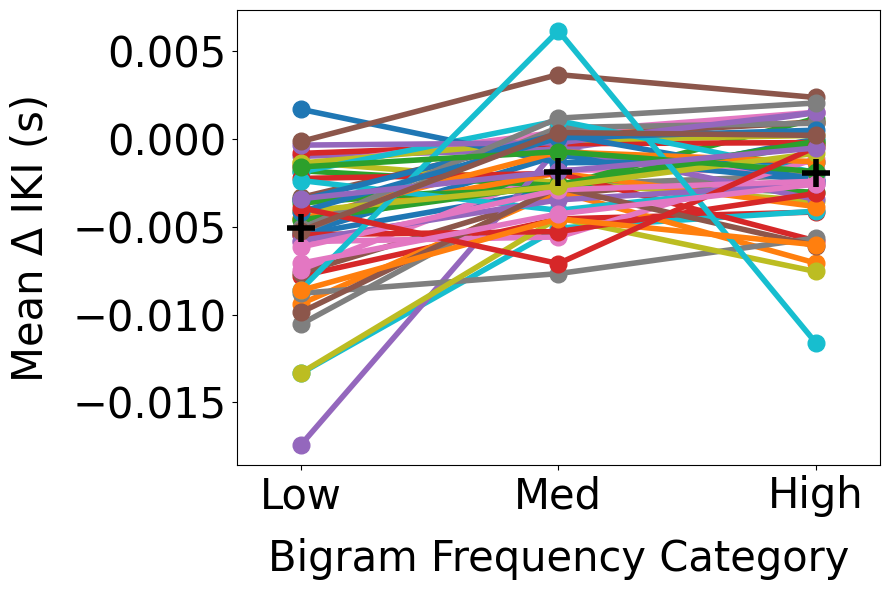

In [81]:
## plotting mean delta iki by BF group

plt.set_cmap('tab20')

x = [2, 4, 6]
D = (all_deltas_bybf[all_deltas_bybf['bf_type'] == 'low']['mean_deltaiki'],
    all_deltas_bybf[all_deltas_bybf['bf_type'] == 'med']['mean_deltaiki'],
    all_deltas_bybf[all_deltas_bybf['bf_type'] == 'high']['mean_deltaiki'])

means = (np.mean(all_deltas_bybf[all_deltas_bybf['bf_type'] == 'low']['mean_deltaiki']),
        np.mean(all_deltas_bybf[all_deltas_bybf['bf_type'] == 'med']['mean_deltaiki']),
        np.mean(all_deltas_bybf[all_deltas_bybf['bf_type'] == 'high']['mean_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-0.129, 0.06])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaiki_bywf.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

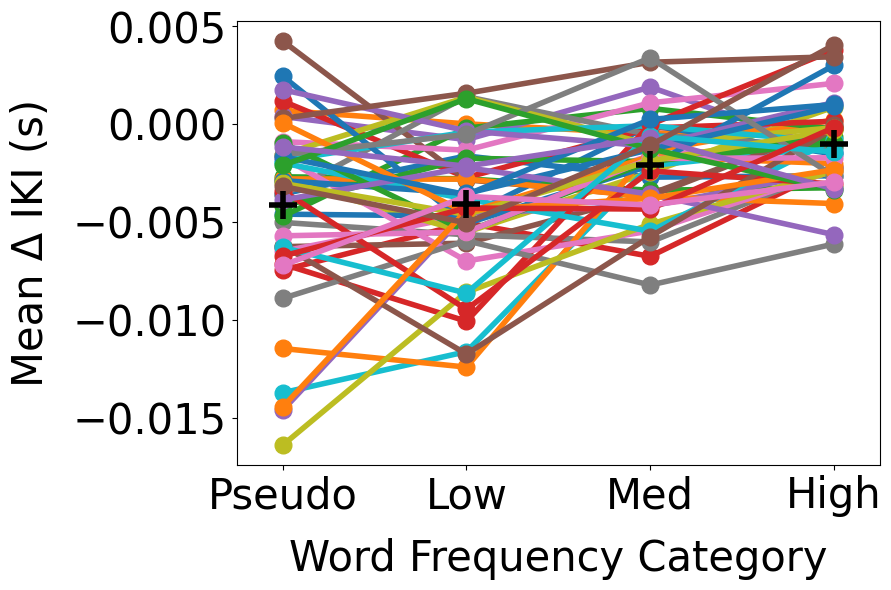

In [82]:
## plotting mean delta iki by WF group

plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (all_deltas_bywf[all_deltas_bywf['wf_type'] == 'pseudo']['mean_deltaiki'],
    all_deltas_bywf[all_deltas_bywf['wf_type'] == 'low']['mean_deltaiki'],
     all_deltas_bywf[all_deltas_bywf['wf_type'] == 'med']['mean_deltaiki'],
    all_deltas_bywf[all_deltas_bywf['wf_type'] == 'high']['mean_deltaiki'])

means = (np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'pseudo']['mean_deltaiki']),
        np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'low']['mean_deltaiki']),
        np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'med']['mean_deltaiki']),
        np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'high']['mean_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-0.129, 0.06])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaiki_bywf.png', dpi=300)
plt.show()

In [83]:
pseudo_strings = corr_trials_bybg[corr_trials_bybg['bf_type'] == 'high']
pseudo_ikis = pseudo_strings.groupby(['sID', 'rep_num']).IKI.agg(['mean']).reset_index()
pseudo_ikis

sID  rep_num      mean
0    s009        0  0.102294
1    s009        1  0.098216
2    s009        2  0.102301
3    s009        3  0.108112
4    s009        4  0.097995
..    ...      ...       ...
465  s352        5  0.109922
466  s352        6  0.109567
467  s352        7  0.111758
468  s352        8  0.121817
469  s352        9  0.108355

[470 rows x 3 columns]

<Figure size 640x480 with 0 Axes>

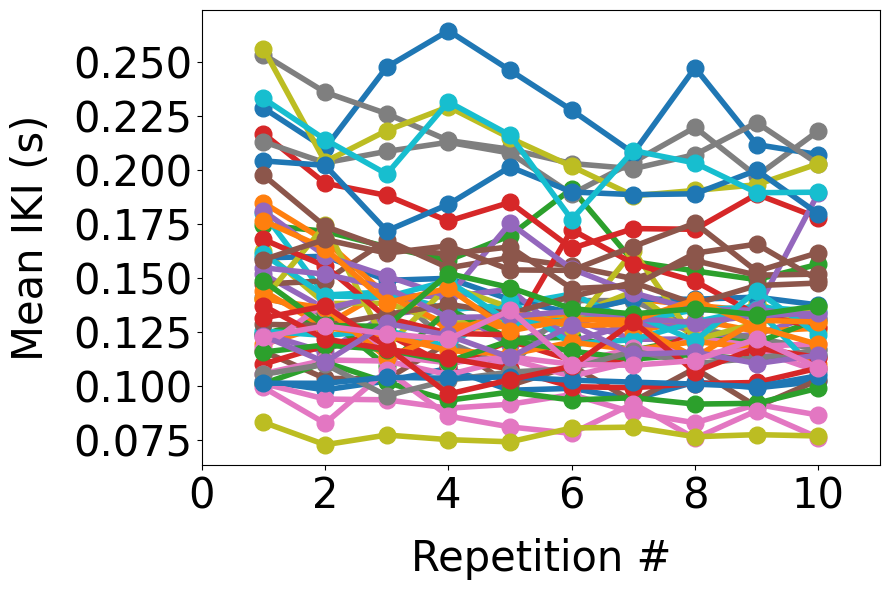

In [84]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_ikis[pseudo_ikis['rep_num'] == 0]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 1]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 2]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 3]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 4]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 5]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 6]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 7]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 8]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 9]['mean'])

# means = (np.mean(mean_rts[mean_rts['wf_type'] == 'pseudo']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'lowwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'medwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meaniki_byrep.png', dpi=300)
plt.show()

## High BF/WF IKIs vs. Simulated Null (currently skipping because it takes so long)

In [85]:
# # Calcuating mean and STD delta IKI of high freq. bigrams
# highbf_df = all_deltas_bybf[all_deltas_bybf['bf_type'] == 'high']
# highbf_mean = highbf_df.mean_deltaiki.mean()
# highbf_std = highbf_df.mean_deltaiki.std()

# # Creating dataframe of mean delta IKIs calculated from shuffled High BF 
# # datasets
# shuff_iki = null_deltas(corr_trials_bybg, 'IKI')
# shuff_highbf = shuff_iki[shuff_iki[2] == 'bf_type']

# # Saving random dataset to report
# # shuff_highbf.to_csv(save_dir + '/shuff_highbf_MMDDYYYY.csv')

# # Printing relevant information
# print('Mean delta IKI of collected high BF bigrams', 
#       highbf_mean, '±',
#       highbf_std)
# print('Average of shuffled mean delta IKIs', 
#       np.mean(shuff_highbf[3]), '±',
#       np.std(shuff_highbf[3]))
# print('estimated p-val:', np.mean(abs(shuff_highbf[3]) > abs(highbf_mean)))

# # Plotting mean delta IKIs of shuffled data and collected high freq. bigrams
# plt.hist(shuff_highbf[3], bins=20)
# plt.axvline(x=highbf_mean, color='red', linestyle='--')

# plt.xlabel("Mean delta IKI")
# plt.title("")

# plt.show()

In [86]:
# # Calcuating mean and STD delta IKI of high freq. words
# highwf_df = all_deltas_bywf[all_deltas_bywf['wf_type'] == 'high']
# highwf_mean = highwf_df.mean_deltaiki.mean()
# highwf_std = highwf_df.mean_deltaiki.std()

# # Creating dataframe of mean delta IKIs calculated from shuffled High WF 
# # datasets
# shuff_highwf = shuff_iki[shuff_iki[2] == 'wf_type']

# # Saving random dataset to report
# # shuff_highwf.to_csv(save_dir + '/shuff_highwf_MMDDYYYY.csv')

# # Printing relevant information
# print('Mean delta IKI of collected high freq. bigrams', 
#       highwf_mean, '±',
#       highwf_std)
# print('Average of shuffled mean delta IKIs', 
#       np.mean(shuff_highwf[3]), '±',
#       np.std(shuff_highwf[3]))
# print('estimated p-val:', np.mean(abs(shuff_highwf[3]) > abs(highwf_mean)))

# # Plotting mean delta IKIs of shuffled data and collected high freq. words
# plt.hist(shuff_highwf[3], bins=20)
# plt.axvline(x=highbf_mean, color='red', linestyle='--')

# plt.xlabel("Mean delta IKI")
# plt.title("")

# plt.show()

## Delta IKI across Bigram Location

In [87]:
deltaiki_byloc = corr_trials_bybg.groupby(['sID', 
                                           'bigram_loc', 
                                           'wf_type']).delta_iki.agg('mean')
deltaiki_byloc = pd.DataFrame(deltaiki_byloc).reset_index()

print(pg.rm_anova(deltaiki_byloc, 'delta_iki', 'bigram_loc', 'sID'))
pg.pairwise_tukey(deltaiki_byloc, 'delta_iki', 'bigram_loc', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc       ng2       eps
0  bigram_loc      3    138  3.462673  0.018133  0.034736  0.776639


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A  B   mean(A)   mean(B)      diff        se         T   p-tukey     cohen
0  0  1 -0.002166 -0.003030  0.000864  0.000553  1.561430  0.401461  0.151172
1  0  2 -0.002166 -0.003689  0.001523  0.000553  2.751235  0.030877  0.274383
2  0  3 -0.002166 -0.002407  0.000241  0.000553  0.435302  0.972371  0.050526
3  1  2 -0.003030 -0.003689  0.000659  0.000553  1.189805  0.633491  0.111546
4  1  3 -0.003030 -0.002407 -0.000623  0.000553 -1.126128  0.673490 -0.120416
5  2  3 -0.003689 -0.002407 -0.001282  0.000553 -2.315933  0.095306 -0.256827

# Total Delta IKI

## Total Delta IKI Statistics

In [88]:
# Calculates delta IKI between first and final trial 
# (last rep IKI - first rep IKI)

def total_deltaiki(dataframe):
    DF = dataframe[dataframe['rep_num'].isin([1,9])]
    total_delta = pd.DataFrame(DF.groupby(['sID', 'string', 'bigram']).IKI.agg(['diff']))
    total_delta.fillna(0, inplace=True)
    if 'total_deltaiki' in dataframe.columns:
        dataframe.replace(dataframe['total_deltaiki'], total_delta)
    else:
        dataframe.insert(len(dataframe.columns), 'total_deltaiki', total_delta)
    last_trials = dataframe[dataframe['rep_num'] == 9]
    return last_trials

# Calculates individual mean of total delta IKI for each subject.
def indiv_totaldeltaiki(dataframe, str_or_bg, typ_group_list):
    all_means = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        totaldelta_DF = total_deltaiki(DF)
        totaldelta_DF = totaldelta_DF[totaldelta_DF['rep_num'] != 0]
        deltas = totaldelta_DF.groupby(['sID', 
                                        'string', 
                                        'bigram']).total_deltaiki.agg(['mean']).reset_index()
        deltas = deltas.rename(columns={'mean': 'total_deltaiki'})
        total_deltaikis = deltas.groupby('sID').total_deltaiki.agg(['mean']).reset_index()
        total_deltaikis = total_deltaikis.rename(columns={'mean': 
                                                          'total_deltaiki'})
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                total_deltaikis['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                total_deltaikis['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             total_deltaikis['bf_type'] = freq_type
        all_means = pd.concat([all_means, total_deltaikis])
    return all_means.reset_index(drop=True)

In [89]:
# indiv_totaldeltaiki(corr_trials_bybg, 'bigram', bf_groups)
# total_deltaiki(corr_trials_bybg)

In [90]:
# anova comparing total delta IKI across BF
all_totaldeltas_bybf = indiv_totaldeltaiki(corr_trials_bybg, 'bigram', bf_groups)

print(pg.rm_anova(all_totaldeltas_bybf, 'total_deltaiki', 'bf_type', 'sID'))
pg.pairwise_tukey(all_totaldeltas_bybf, 'total_deltaiki', 'bf_type', effsize='cohen')

/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


    Source  ddof1  ddof2        F     p-unc      ng2       eps
0  bf_type      2     92  8.32633  0.000475  0.08238  0.730386


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low -0.008280 -0.021398  0.013118  0.004076  3.218635  0.004549   
1  high  med -0.008280 -0.009811  0.001531  0.004076  0.375588  0.925236   
2   low  med -0.021398 -0.009811 -0.011587  0.004076 -2.843046  0.014165   

      cohen  
0  0.623589  
1  0.099032  
2 -0.523666

In [91]:
# anova comparing total delta IKI across BF
all_totaldeltas_bywf = indiv_totaldeltaiki(corr_trials_bybg, 'string', wf_groups)

print(pg.rm_anova(all_totaldeltas_bywf, 'total_deltaiki', 'wf_type', 'sID'))
pg.pairwise_tukey(all_totaldeltas_bywf, 'total_deltaiki', 'wf_type', effsize='cohen')

/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


    Source  ddof1  ddof2         F     p-unc       ng2       eps
0  wf_type      3    138  5.465258  0.001403  0.060698  0.883745


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.006226 -0.020506  0.014280  0.004223  3.381837  0.004837   
1  high     med -0.006226 -0.011028  0.004802  0.004223  1.137217  0.667011   
2  high  pseudo -0.006226 -0.013314  0.007089  0.004223  1.678742  0.337859   
3   low     med -0.020506 -0.011028 -0.009478  0.004223 -2.244620  0.115229   
4   low  pseudo -0.020506 -0.013314 -0.007192  0.004223 -1.703095  0.325011   
5   med  pseudo -0.011028 -0.013314  0.002287  0.004223  0.541526  0.948713   

      cohen  
0  0.722055  
1  0.271060  
2  0.310981  
3 -0.531144  
4 -0.314107  
5  0.108168

## Total Delta IKI Figures

<Figure size 640x480 with 0 Axes>

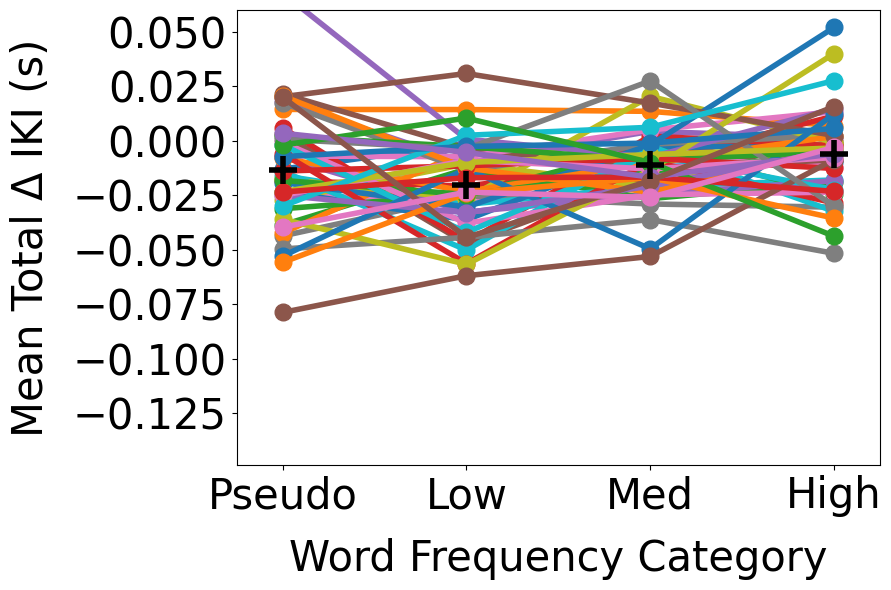

In [92]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'pseudo']['total_deltaiki'],
    all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'low']['total_deltaiki'],
    all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'med']['total_deltaiki'],
    all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'high']['total_deltaiki'])

means = (np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'pseudo']['total_deltaiki']),
        np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'low']['total_deltaiki']),
        np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'med']['total_deltaiki']),
        np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'high']['total_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-0.149, 0.060])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Total Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/totaldeltaiki_bywf.png', dpi=300)
plt.show()

## Total Delta IKI across Bigram Location

In [93]:
# Comparing Mean Total Delta IKI across bigram locations
deltas = total_deltaiki(corr_trials_bybg)
total_deltaiki_byloc = deltas.groupby(['sID', 'bigram_loc']).total_deltaiki.agg('mean')
total_deltaiki_byloc = pd.DataFrame(total_deltaiki_byloc).reset_index()

print(pg.rm_anova(total_deltaiki_byloc, 'total_deltaiki', 'bigram_loc', 'sID'))
pg.pairwise_tukey(total_deltaiki_byloc, 'total_deltaiki', 'bigram_loc', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc       ng2       eps
0  bigram_loc      3    138  1.724402  0.164838  0.023158  0.856412


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A  B   mean(A)   mean(B)      diff        se         T   p-tukey     cohen
0  0  1 -0.008860 -0.013576  0.004716  0.004633  1.017893  0.739185  0.200312
1  0  2 -0.008860 -0.017668  0.008808  0.004633  1.901082  0.231166  0.412500
2  0  3 -0.008860 -0.010109  0.001249  0.004633  0.269678  0.993120  0.056323
3  1  2 -0.013576 -0.017668  0.004092  0.004633  0.883189  0.813590  0.180000
4  1  3 -0.013576 -0.010109 -0.003467  0.004633 -0.748215  0.877332 -0.147419
5  2  3 -0.017668 -0.010109 -0.007558  0.004633 -1.631404  0.363582 -0.354502

In [94]:
# Comparing Mean Delta IKI across bigram locations
deltas = corr_trials_bybg[['sID', 'bigram_loc', 'delta_iki']].copy()
deltaiki_byloc = deltas.groupby(['sID', 'bigram_loc']).delta_iki.agg('mean')
deltaiki_byloc = pd.DataFrame(deltaiki_byloc).reset_index()

print(pg.rm_anova(deltaiki_byloc, 'delta_iki', 'bigram_loc', 'sID'))
pg.pairwise_tukey(deltaiki_byloc, 'delta_iki', 'bigram_loc', effsize='cohen')

/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


       Source  ddof1  ddof2         F     p-unc       ng2       eps
0  bigram_loc      3    138  3.419949  0.019154  0.034287  0.773277


A  B   mean(A)   mean(B)      diff        se         T   p-tukey     cohen
0  0  1 -0.002171 -0.003026  0.000855  0.000648  1.319435  0.551752  0.264353
1  0  2 -0.002171 -0.003677  0.001505  0.000648  2.324369  0.096241  0.459034
2  0  3 -0.002171 -0.002404  0.000233  0.000648  0.359361  0.984063  0.089701
3  1  2 -0.003026 -0.003677  0.000651  0.000648  1.004933  0.746723  0.180636
4  1  3 -0.003026 -0.002404 -0.000622  0.000648 -0.960075  0.772238 -0.207733
5  2  3 -0.003677 -0.002404 -0.001273  0.000648 -1.965008  0.205109 -0.418105

In [95]:
# # Plotting Mean Total Delta IKI across bigram locations
# diffs = deltas[deltas['rep_num'] == 9].sort_values(by=['sID', 'string'])
# indiv_diffs = pd.DataFrame(diffs.groupby(['sID', 
#                                           'bigram_loc']).total_deltaiki.agg('mean')).reset_index()

# x = (2, 4, 6, 8)
# D = (indiv_diffs.groupby(['bigram_loc']).total_deltaiki.mean())
# st_dev = (indiv_diffs.groupby(['bigram_loc']).total_deltaiki.std())

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.errorbar(x, D, st_dev, c='r')
# plt.show()

# Repetition Effects

In [96]:
# Mean IKI of first reps vs mean IKI of last reps by individual (across all categories)
rep1 = corr_trials_bybg[corr_trials_bybg['rep_num'] == 0]
rep1_meaniki = rep1.groupby('sID').IKI.agg(['mean']).reset_index(drop=True)
rep1_rt = rep1[rep1['bigram_loc'] == 0]
rep1_meanrt = rep1_rt.groupby('sID').IKI.agg(['mean']).reset_index(drop=True)

rep10 = corr_trials_bybg[corr_trials_bybg['rep_num'] == 9]
rep10_meaniki = rep10.groupby('sID').IKI.agg('mean').reset_index(drop=True)
rep10_rt = rep10[rep10['bigram_loc'] == 0]
rep10_meanrt = rep10_rt.groupby('sID').IKI.agg(['mean']).reset_index(drop=True)

print('mean IKI:')
print(pg.ttest(rep1_meaniki['mean'], rep10_meaniki, paired=True))
print('mean RT:')
print(pg.ttest(rep1_meanrt['mean'], rep10_meanrt['mean'], paired=True))

mean IKI:
              T  dof alternative         p-val         CI95%   cohen-d  \
T-test  7.22471   46   two-sided  4.197642e-09  [0.02, 0.03]  0.523873   

             BF10     power  
T-test  2.885e+06  0.940096  
mean RT:
               T  dof alternative     p-val         CI95%   cohen-d    BF10  \
T-test  4.399415   46   two-sided  0.000064  [0.01, 0.03]  0.358296  351.74   

           power  
T-test  0.671793  


In [97]:
# ## plotting overall bg repetition effect
# plt.rcParams.update(plt.rcParamsDefault)
# # plt.style.use('fast')
# plt.set_cmap('tab20')

# x = ('first_rep', 'last_rep')
# D = (rep1_meaniki.mean.mean(), rep10_meaniki.mean.mean())
# sds = (rep1_meaniki.mean.std(), rep10_meaniki.mean.std())

# plt.bar(x, D, color = 'deepskyblue', width = 0.4)
# plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

# plt.show()

In [98]:
## repetition effect of high freq bgs
highbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_firstrep = highbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_lastrep = highbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highbf_diffs = (highbf_lastrep.IKI - highbf_firstrep.IKI)

## repetition effect of low freq bgs
lowbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_firstrep = lowbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_lastrep = lowbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowbf_diffs = (lowbf_lastrep.IKI - lowbf_firstrep.IKI)

pg.ttest(highbf_diffs, lowbf_diffs)
highbf_lastrep

index   sID  bigram_num  trial_num  rep_num  bigram_loc bigram  \
9       840  s009         840        210        9           2     ou   
12      883  s009         883        221        9           1     ha   
7       831  s009         831        208        9           1     he   
8       833  s009         833        208        9           3     er   
11      881  s009         881        220        9           3     ed   
...     ...   ...         ...        ...      ...         ...    ...   
1382  32640  s352         842        209        9           1     it   
1383  32641  s352         843        209        9           2     th   
1384  32642  s352         844        209        9           3     he   
1385  32652  s352         854        212        9           1     an   
1408  32747  s352         949        236        9           1     ou   

     resp_bigram       IKI string resp_string     bg_freq bf_type meanbf_type  \
9             ou  0.055787  about       about   7425307.0    high         med   
12            ha  0.111921  champ       champ   6967591.0    high         med   
7             he  0.135950  cheer       cheer  21484684.0    high        high   
8             er  0.095798  cheer       cheer  12934901.0    high        high   
11            ed  0.192099  cooed       cooed   7805967.0    high         med   
...          ...       ...    ...         ...         ...     ...         ...   
1382          it  0.119998  tithe       tithe   6637233.0    high        high   
1383          th  0.095970  tithe       tithe  22288309.0    high        high   
1384          he  0.096022  tithe       tithe  21484684.0    high        high   
1385          an  0.056017  vanru       vanru  12315713.0    high         med   
1408          ou  0.159965  would       would   7425307.0    high         med   

     wf_type  trial_corr  bg_corr  delta_iki  total_deltaiki  
9       high        True     True   0.023970       -0.007968  
12       med        True     True   0.015955       -0.008173  
7        med        True     True   0.015982       -0.000108  
8        med        True     True   0.039873        0.007967  
11       low        True     True   0.008206        0.024044  
...      ...         ...      ...        ...             ...  
1382     low        True     True  -0.008031       -0.015990  
1383     low        True     True   0.008001       -0.000062  
1384     low        True     True  -0.032102       -0.023930  
1385  pseudo        True     True  -0.055933       -0.079904  
1408    high        True     True  -0.016074       -0.032180  

[1410 rows x 19 columns]

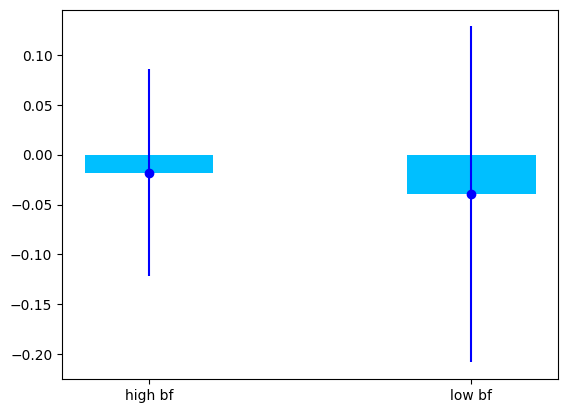

In [99]:
## plotting repetition effect on high vs low freq bgs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high bf', 'low bf')
D = (highbf_diffs.mean(), lowbf_diffs.mean())
sds = (highbf_diffs.std(), lowbf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [100]:
## repetition effect of high freq wfs
highwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_firstrep = highwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_lastrep = highwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highwf_diffs = (highwf_lastrep.IKI - highwf_firstrep.IKI).reset_index(drop=True)

## repetition effect of low freq wfs
lowwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_firstrep = lowwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_lastrep = lowwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowwf_diffs = (lowwf_lastrep.IKI - lowwf_firstrep.IKI).reset_index(drop=True)

pg.ttest(highwf_diffs, lowwf_diffs)

T          dof alternative    p-val         CI95%   cohen-d  \
T-test  3.387914  1745.337714   two-sided  0.00072  [0.01, 0.03]  0.151905   

          BF10     power  
T-test  14.697  0.926208

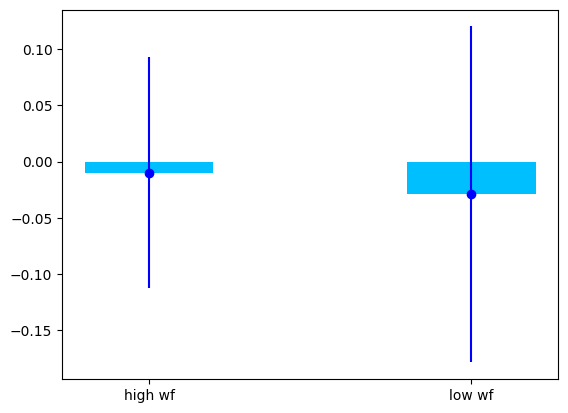

In [101]:
## plotting repetition effect on high vs low freq wfs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high wf', 'low wf')
D = (highwf_diffs.mean(), lowwf_diffs.mean())
sds = (highwf_diffs.std(), lowwf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [102]:
# x = [(2, 4, 6, 8), (2, 4, 6, 8)]
# D = [first_reps.groupby('bigram_loc').IKI.mean(),
#      last_reps.groupby('bigram_loc').IKI.mean()]
# st_dev = [first_reps.groupby('bigram_loc').IKI.std(),
#           last_reps.groupby('bigram_loc').IKI.std()]

# fig, ax = plt.subplots(figsize=(9, 6))
# # ax.plot(x, D, '.-', linewidth=4, ms=24)
# plt.errorbar(x[0], D[0], st_dev[0], c='r')
# plt.errorbar(x[1], D[1], st_dev[1], c='b')

# plt.show()

# Individual Differences

## Sensitivity to individual differences

In [103]:
## calculating senstivity to individual differences (with weird metric I made up)
# D = pd.concat([indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf'), 
#      indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf'),
#      indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')])

# high_bf

# np.mean(choose2(D['Avg IKI'], operation = abs_difference))
perms = list(it.permutations(indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI'], 2))
# for x in perms:
#     abs(x[1] - x[2])

sample_diffs = [abs(x[0] - x[1]) for x in perms]
indiv_sens = np.mean(sample_diffs)/np.mean(indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI'])
indiv_sens

np.float64(0.4055281375193554)

In [104]:
# Runs pearson correlation across for a given metric across all bigram/word 
# frequency category permutations.
def metric_corr(dataframe, metric):
    if 'bf_type' in dataframe.columns:
        freq_type = 'bf_type'
        freq_types = ['low', 'med', 'high']
    elif 'wf_type' in dataframe.columns:
        freq_type = 'wf_type'
        freq_types = ['pseudo', 'low', 'med', 'high']
    no_bon = []
    for freq1 in freq_types:
        for freq2 in freq_types:
            pearson = pearsonr(dataframe[dataframe[freq_type] == freq1][metric], 
                              dataframe[dataframe[freq_type] == freq2][metric])
            no_bon.append([freq1, freq2, pearson[0], pearson[1]])
    comp_vals = pd.DataFrame(no_bon).rename(columns={0: 'freq1', 
                                                     1: 'freq2',
                                                     2: 'r_stat',
                                                     3: 'no_bon_pval'})
    no_bon_pvals = comp_vals['no_bon_pval']
    comp_vals['bon_pvals'] = [p*len(no_bon_pvals) for p in no_bon_pvals]
    comp_vals['freq_type'] = f"{freq_type}"
    comp_vals['metric'] = f"{metric}"
    return comp_vals

# Calculates all correlations for a given set of frequency types and metrics.
def combine_corrs(df_list, metric_list):
    all_corrs = pd.DataFrame()
    for dataframe in df_list:
        for metric in metric_list:
            one_corr = metric_corr(dataframe, metric)
            all_corrs = pd.concat([all_corrs, one_corr])
    return all_corrs.reset_index(drop=True)

In [105]:
# Calculates pearson correlations for Mean, SD, and CV IKI across all bigram and
# word frequencies.
df_list = [all_bybf, all_bywf]
metric_list = ['mean_IKI', 'sd_IKI', 'cv_IKI']

within_task_corrs = combine_corrs(df_list, metric_list)

within_task_corrs[within_task_corrs['bon_pvals'] > 0.05]

freq1   freq2    r_stat  no_bon_pval  bon_pvals freq_type  metric
62  pseudo    high  0.341824     0.018690   0.299044   wf_type  cv_IKI
66     low    high  0.262653     0.074484   1.191737   wf_type  cv_IKI
70     med    high  0.387343     0.007148   0.114363   wf_type  cv_IKI
71    high  pseudo  0.341824     0.018690   0.299044   wf_type  cv_IKI
72    high     low  0.262653     0.074484   1.191737   wf_type  cv_IKI
73    high     med  0.387343     0.007148   0.114363   wf_type  cv_IKI

In [106]:
# Calculating pearson correlations
# pcorr_mean_bf = metric_corr(all_bybf, 'bf_type', 'mean_IKI')

# # Load converting data to long form
# heat_mean_bf = (
#     pcorr_mean_wf
#     .pivot(index="freq1", columns="freq2", values="r_stat")
# )

# heat_mean_bf = heat_mean_bf.reindex(columns=['pseudo', 'low', 'med', 'high'],
#                                     index=['high', 'med', 'low', 'pseudo'])

# # Draw a heatmap with the numeric values in each cell
# f, ax = plt.subplots(figsize=(9, 6))
# sns.heatmap(heat_mean_bf, annot=True, cmap='flare', linewidths=.5, ax=ax)
# plt.show()

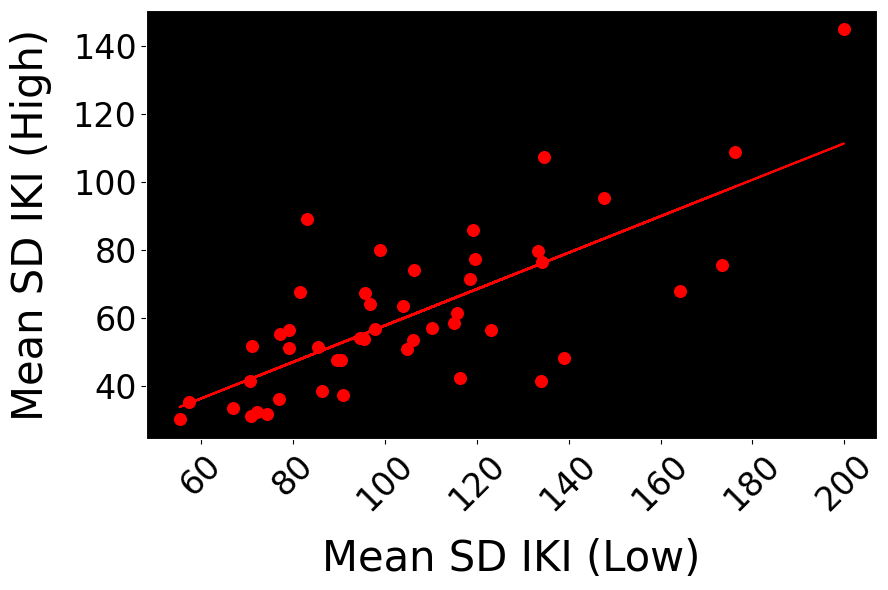

In [107]:
##plotting sd correlation
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'], 
            all_bybf[all_bybf['bf_type'] == 'high']['sd_IKI'], 
            s = 70, color = 'red')

z = np.polyfit(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'], 
               all_bybf[all_bybf['bf_type'] == 'high']['sd_IKI'], 1)
p = np.poly1d(z)
plt.plot(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'],
         p(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI']),
         color = 'red')

plt.xlabel("Mean SD IKI (Low)", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (High)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
# plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'SD_correlation_bysub', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## Individual metrics across all bigrams/trials for Turbo analysis

In [108]:
# Calcuating individual metrics across all trials/bigrams
iki_global = indiv_ikimetric(corr_trials_bybg, 'string', no_groups, iki_metrics)
rt_global = indiv_rtmetric(corr_trials, no_groups, iki_metrics)
deltaiki_global = indiv_meandeltaiki(corr_trials_bybg, 'string', no_groups)
totaldeltaiki_global = indiv_totaldeltaiki(corr_trials_bybg, 'string', no_groups)
deltart_global = indiv_deltart(corr_trials, no_groups)
error_global = all_ikimetric(indiv_error, incorr_bgs, 'string', no_groups)

# Concetenating into one dataframe and exporting to .csv.
indiv_globalmetrics = pd.concat([iki_global,
                                 rt_global,
                                 deltaiki_global,
                                 totaldeltaiki_global,
                                 deltart_global,
                                 error_global], axis = 1)
indiv_globalmetrics = indiv_globalmetrics.loc[:, ~indiv_globalmetrics.columns.duplicated()]
indiv_globalmetrics = indiv_globalmetrics.drop(['wf_type', 'index'], axis = 1)

indiv_globalmetrics.to_csv(save_dir + '/indiv_globalmetrics.csv')

# Delta CV and SD

In [109]:
# Calculates decreases in variability from high to low bigram frequency 
# categories.

def variation_diff(df):
    diffs = []
    if 'bf_type' in df.columns:
        bf_or_wf = 'bf_type'
    elif 'wf_type' in df.columns:
        bf_or_wf = 'wf_type'
    for metric in ['sd_IKI', 'cv_IKI']:
        low = list(df[(df[bf_or_wf] == 'low')][metric])
        high = list(df[(df[bf_or_wf] == 'high')][metric])
        diff = high[0] - low[0]
        diffs.append(diff)
    return diffs

# Creating and exporting dataframe of delta variation by bigram freq.
delta_vars_bybf = pd.DataFrame(all_bybf.groupby('sID').apply(lambda df: variation_diff(df), include_groups=False)).reset_index()
diff_cols = pd.DataFrame(delta_vars_bybf[0].to_list(), columns = ['sd_diff', 
                                                                  'cv_diff'])
delta_vars_bybf = pd.concat([delta_vars_bybf, diff_cols], axis=1)
delta_vars_bybf = delta_vars_bybf.drop(0, axis=1)

delta_vars_bybf.to_csv(save_dir + '/delta_vars_bybf.csv')

# Creating and exporting dataframe of delta variation by word freq.
delta_vars_bywf = pd.DataFrame(all_bywf.groupby('sID').apply(lambda df: variation_diff(df), include_groups=False)).reset_index()
diff_cols = pd.DataFrame(delta_vars_bywf[0].to_list(), columns = ['sd_diff', 
                                                                  'cv_diff'])
delta_vars_bywf = pd.concat([delta_vars_bywf, diff_cols], axis=1)
delta_vars_bywf = delta_vars_bywf.drop(0, axis=1)

delta_vars_bywf.to_csv(save_dir + '/delta_vars_bywf.csv')

# Paper Figures

## Fig. 1

In [110]:
# Melting IKI data into correct format
# for freq_type in freq_types:
    
bybf_melted = all_bybf.melt(id_vars=['sID', 'bf_type'],
                            value_vars=['mean_IKI', 'sd_IKI', 'cv_IKI'],
                            var_name='IKI_metric',
                            value_name='value')
bybf_melted['freq_type'] = 'bf_type'
bybf_melted = bybf_melted.rename(columns={'bf_type':'freq'})

bywf_melted = all_bywf.melt(id_vars=['sID', 'wf_type'],
                            value_vars=['mean_IKI', 'sd_IKI', 'cv_IKI'],
                            var_name='IKI_metric',
                            value_name='value')
bywf_melted['freq_type'] = 'wf_type'
bywf_melted = bywf_melted.rename(columns={'wf_type':'freq'})

graph_data = pd.concat([bybf_melted, bywf_melted])

# Melting RT data into correct format
rtbf_melted = rt_bywf.melt(id_vars=['sID', 'wf_type'],
                            value_vars=['mean_RT', 'sd_RT', 'cv_RT'],
                            var_name='IKI_metric',
                            value_name='value')

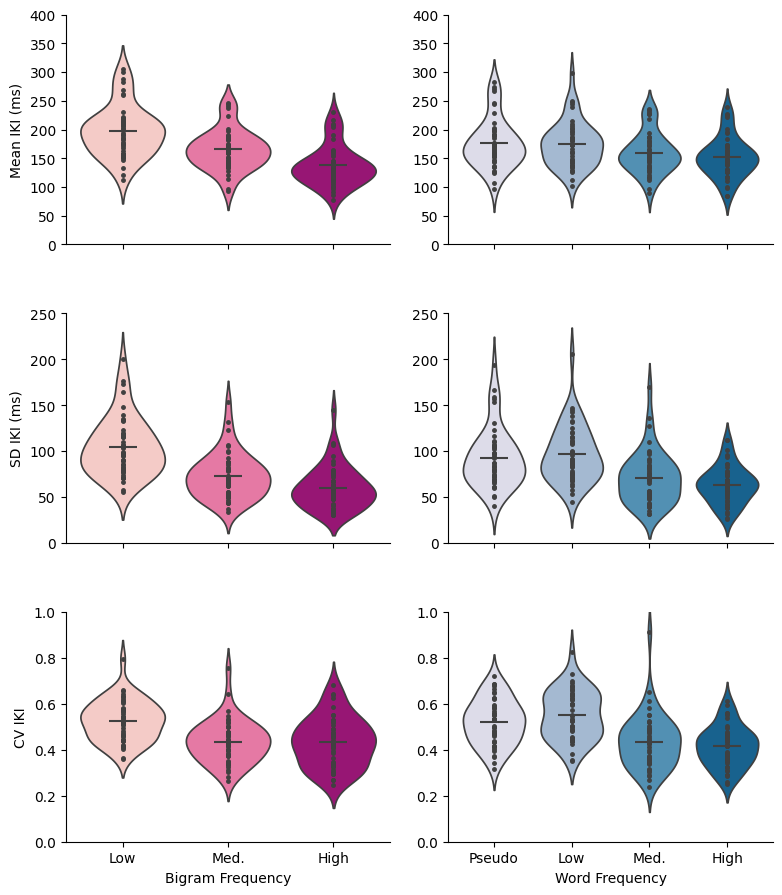

In [111]:
# Fig. 1a - Mean, SD, CV IKI for BF and WF categories

# Making palette and hue dictionaries
palette_dict = {'bf_type': 'RdPu', 'wf_type': 'PuBu'}
hue_order_dict = {'bf_type': ['low', 'med', 'high'],
                  'wf_type': ['pseudo', 'low', 'med', 'high']}

# Making facetgrid
g = sns.FacetGrid(graph_data, 
                  col='freq_type', 
                  row='IKI_metric', 
                  hue='freq',
                  sharey=False,
                  sharex=False,
                  height=3,
                  aspect=1.3)

# Making each column use a different color palette
for (bf_or_wf, ax) in g.axes_dict.items():
    palette = palette_dict[bf_or_wf[1]]
    hue_order = hue_order_dict[bf_or_wf[1]]
    data = graph_data[(graph_data['freq_type'] == bf_or_wf[1]) 
                    & (graph_data['IKI_metric'] == bf_or_wf[0])]
    sns.violinplot(data, 
                   x='freq', 
                   y='value', 
                   hue='freq', 
                   hue_order=hue_order, 
                   palette=palette, 
                   ax=ax,
                   edgecolor='0.25',
                   inner='point',
                   inner_kws=dict(edgecolor='0.25', color=".25"))
    violin_means = data.groupby(['freq_type', 
                                 'freq']).value.agg('mean').reset_index()
    if bf_or_wf[1] == 'bf_type':
        categories = ['low', 'med', 'high']
    elif bf_or_wf[1] == 'wf_type':
        categories = ['pseudo', 'low', 'med', 'high']
    violin_means['freq'] = pd.Categorical(violin_means['freq'],
                                              categories=categories,
                                              ordered=True)                          
    violin_means = violin_means.sort_values(by="freq")
    sns.scatterplot(x=range(len(violin_means['value'])), y=violin_means['value'], 
                    color='0.25', ax=ax,
                    marker='_', linewidth=1.5, s=400)

    
# Getting rid of facet titles
g.set_titles(template="")

# Setting y-axis limits for respective rows
g.axes[0, 0].set_ylim(0, 400)
g.axes[1, 0].set_ylim(0, 250)
g.axes[2, 0].set_ylim(0, 1)
g.axes[0, 1].set_ylim(0, 400)
g.axes[1, 1].set_ylim(0, 250)
g.axes[2, 1].set_ylim(0, 1)

# Setting y-labels
g.axes[0, 0].set_ylabel('Mean IKI (ms)')
g.axes[1, 0].set_ylabel('SD IKI (ms)')
g.axes[2, 0].set_ylabel('CV IKI')
g.axes[0, 1].set_ylabel('')
g.axes[1, 1].set_ylabel('')
g.axes[2, 1].set_ylabel('')

# Setting x-labels
g.axes[0, 0].set_xlabel('')
g.axes[1, 0].set_xlabel('')
g.axes[2, 0].set_xlabel('Bigram Frequency')
g.axes[0, 1].set_xlabel('')
g.axes[1, 1].set_xlabel('')
g.axes[2, 1].set_xlabel('Word Frequency')

# Setting x-ticks and labels
g.axes[0, 0].set_xticks([0, 1, 2], ['', '', ''])
g.axes[1, 0].set_xticks([0, 1, 2], ['', '', ''])
g.axes[2, 0].set_xticks([0, 1, 2], ['Low', 'Med.', 'High'])
g.axes[0, 1].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[1, 1].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[2, 1].set_xticks([0, 1, 2, 3], ['Pseudo', 'Low', 'Med.', 'High'])

# Adjusting horizontal space between subplots
plt.subplots_adjust(hspace=0.3)

plt.show()
g.savefig(save_dir + 'fig_1a.png', dpi=300)

In [112]:
rtbf_melted

sID wf_type IKI_metric        value
0    s009  pseudo    mean_RT   673.829627
1    s020  pseudo    mean_RT  1238.065852
2    s175  pseudo    mean_RT   869.944190
3    s176  pseudo    mean_RT   961.535158
4    s178  pseudo    mean_RT   860.411068
..    ...     ...        ...          ...
559  s348    high      cv_RT     0.096089
560  s349    high      cv_RT     0.139070
561  s350    high      cv_RT     0.136477
562  s351    high      cv_RT     0.205963
563  s352    high      cv_RT     0.145538

[564 rows x 4 columns]

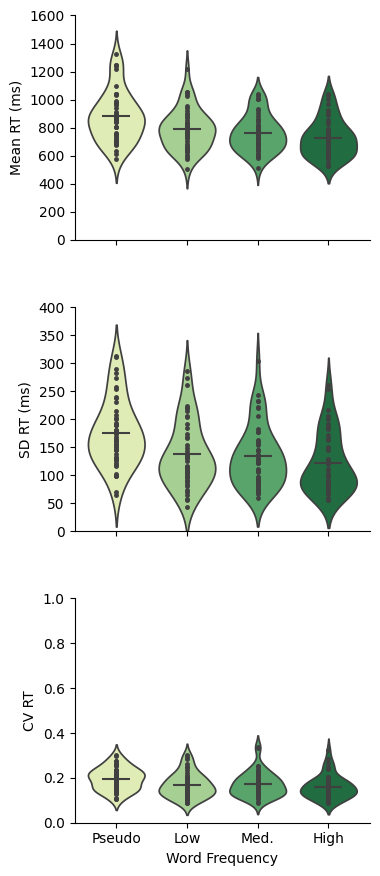

In [113]:
# Fig. 1b - Mean, SD, CV RT for WF categories
g = sns.FacetGrid(rtbf_melted,  
                  row='IKI_metric', 
                  hue='wf_type',
                  palette='YlGn',
                  sharey=False,
                  sharex=False,
                  height=3,
                  aspect=1.3)

g.map(sns.violinplot, 
      'wf_type',              
      'value',               
      order=['pseudo', 'low', 'med', 'high'],
      edgecolor='.25',
      inner = 'point',
      inner_kws=dict(edgecolor='0.25', color=".25"))

violin_means = rtbf_melted.groupby(['wf_type', 
                             'IKI_metric']).value.agg('mean').reset_index()
for (metric, ax) in g.axes_dict.items():
    subplot_means = violin_means[violin_means['IKI_metric'] == metric].copy()
    categories = ['pseudo', 'low', 'med', 'high']
    subplot_means['wf_type'] = pd.Categorical(subplot_means['wf_type'],
                                              categories=categories,
                                              ordered=True)                          
    subplot_means = subplot_means.sort_values(by="wf_type")
    sns.scatterplot(x=range(len(subplot_means['value'])), y=subplot_means['value'], 
                color='0.25', ax=ax,
                marker='_', linewidth=1.5, s=400, legend=False)
    
# Getting rid of facet titles
g.set_titles(template="")

# Setting y-axis limits for respective rows
g.axes[0, 0].set_ylim(0, 1600)
g.axes[1, 0].set_ylim(0, 400)
g.axes[2, 0].set_ylim(0, 1)

# Setting y-labels
g.axes[0, 0].set_ylabel('Mean RT (ms)')
g.axes[1, 0].set_ylabel('SD RT (ms)')
g.axes[2, 0].set_ylabel('CV RT')

# Setting x-labels
g.axes[0, 0].set_xlabel('')
g.axes[1, 0].set_xlabel('')
g.axes[2, 0].set_xlabel('Word Frequency')

# Setting x-ticks and labels
g.axes[0, 0].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[1, 0].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[2, 0].set_xticks([0, 1, 2, 3], ['Pseudo', 'Low', 'Med.', 'High'])

# Adjusting horizontal space between subplots
plt.subplots_adjust(hspace=0.3)

plt.show()
g.savefig(save_dir + 'fig_1b.png', dpi=300)

## Fig. 2

In [114]:
# Formatting error data into correct format
all_errors_bybf['freq_type'] = 'bf_type'
all_errors_bybf = all_errors_bybf.rename(columns={'bf_type':'freq'})

all_errors_bywf['freq_type'] = 'wf_type'
all_errors_bywf = all_errors_bywf.rename(columns={'wf_type':'freq'})

fig2_data = pd.concat([all_errors_bybf, all_errors_bywf])

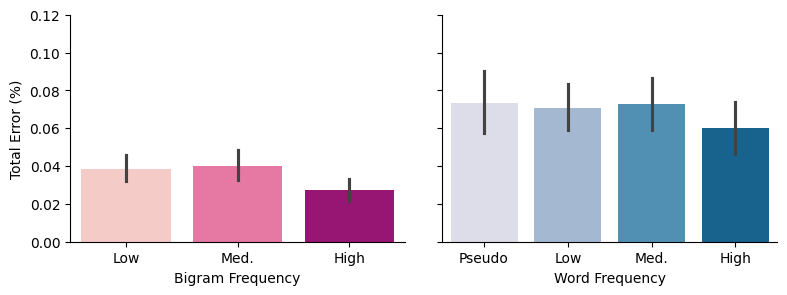

In [115]:
# Fig. 2 - Total Error count for BF and WF categories

# Making palette and hue dictionaries
palette_dict = {'bf_type': 'RdPu', 'wf_type': 'PuBu'}
hue_order_dict = {'bf_type': ['low', 'med', 'high'],
                  'wf_type': ['pseudo', 'low', 'med', 'high']}

# Making facetgrid
g = sns.FacetGrid(fig2_data, 
                  col='freq_type',
                  sharey=True,
                  sharex=False,
                  height=3,
                  aspect=1.3)

# Making each column use a different color palette
for (bf_or_wf, ax) in g.axes_dict.items():
    palette = palette_dict[bf_or_wf]
    hue_order = hue_order_dict[bf_or_wf]
    sns.barplot(data=fig2_data[(fig2_data['freq_type'] == bf_or_wf)], 
                   x='freq', 
                   y='relative_error', 
                   hue='freq', 
                   hue_order=hue_order, 
                   palette=palette, 
                   ax=ax)
                   # edgecolor='0.25')
    
# Getting rid of facet titles
g.set_titles(template="")

# Setting y-axis limits for respective rows
g.axes[0, 0].set_ylim(0, 0.12)
g.axes[0, 1].set_ylim(0, 0.12)

# Setting y-labels
g.axes[0, 0].set_ylabel('Total Error (%)')
g.axes[0, 1].set_ylabel('')

# Setting x-labels
g.axes[0, 0].set_xlabel('Bigram Frequency')
g.axes[0, 1].set_xlabel('Word Frequency')

# Setting x-ticks and labels
g.axes[0, 0].set_xticks([0, 1, 2], ['Low', 'Med.', 'High'])
g.axes[0, 1].set_xticks([0, 1, 2, 3], ['Pseudo', 'Low', 'Med.', 'High'])

plt.show()
g.savefig(save_dir + 'fig_2.png', dpi=300)

## Fig. 3

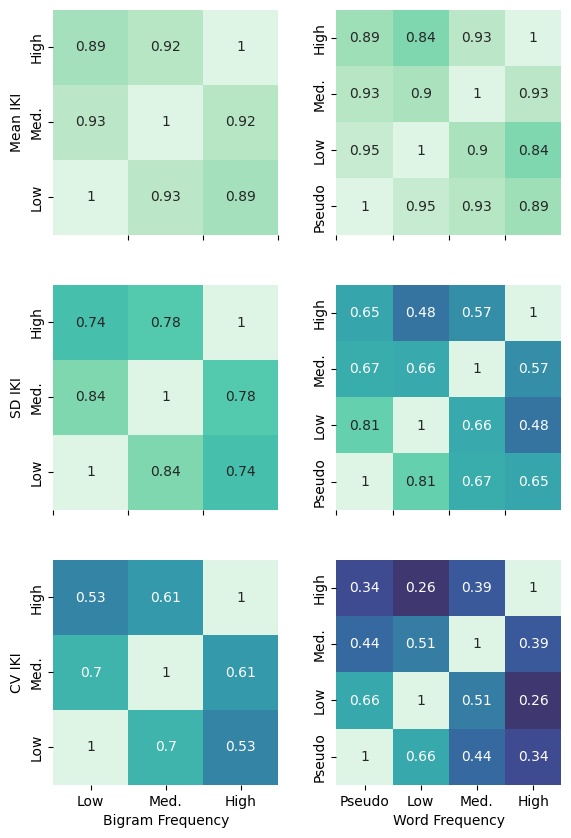

In [116]:
# Fig. 3a - Pearson correlation r-statistics for Mean, SD, and CV IKI

# Setting data variable
all_heat_data = combine_corrs(df_list, metric_list)

# Function to produce heatmaps based on data for a given frequency type and 
# metric of interest.
def draw_heatmap(data, **kwargs):
    heat_data = (data.pivot(index="freq1", columns="freq2", values="r_stat"))
    cols = heat_data.columns.unique().tolist()
    if 'pseudo' in cols:
        heat_data = heat_data.reindex(columns=['pseudo', 'low', 
                                               'med', 'high'],
                                      index=['high', 'med', 
                                             'low', 'pseudo'])
    else: 
        heat_data = heat_data.reindex(columns=['low', 'med', 'high'],
                                      index=['high', 'med', 'low'])
    sns.heatmap(heat_data, square=True, cbar=False, **kwargs)

# Creates facet grid for heat maps.
g = sns.FacetGrid(all_heat_data, 
                  col='freq_type', 
                  row='metric',
                  margin_titles=True,
                  sharex=False,
                  sharey=False)

# Plots heatmaps
g.map_dataframe(draw_heatmap, cmap='mako', annot=True, vmin=0, vmax=1)

# Getting rid of facet titles
g.set_titles(col_template="", row_template="")

# Setting y-labels
g.axes[0, 0].set_ylabel('Mean IKI')
g.axes[1, 0].set_ylabel('SD IKI')
g.axes[2, 0].set_ylabel('CV IKI')
g.axes[0, 1].set_ylabel('')
g.axes[1, 1].set_ylabel('')
g.axes[2, 1].set_ylabel('')

# Setting x-labels
g.axes[0, 0].set_xlabel('')
g.axes[1, 0].set_xlabel('')
g.axes[2, 0].set_xlabel('Bigram Frequency')
g.axes[0, 1].set_xlabel('')
g.axes[1, 1].set_xlabel('')
g.axes[2, 1].set_xlabel('Word Frequency')

# Setting x-ticks and labels
g.axes[0, 0].set_xticks([1, 2, 3], ['', '', ''])
g.axes[1, 0].set_xticks([0, 1, 2], ['', '', ''])
g.axes[2, 0].set_xticks([0.5, 1.5, 2.5], ['Low', 'Med.', 'High'])
g.axes[0, 1].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[1, 1].set_xticks([0, 1, 2, 3], ['', '', '', ''])
g.axes[2, 1].set_xticks([0.5, 1.5, 2.5, 3.5], ['Pseudo', 'Low', 'Med.', 'High'])

# Setting y-ticks and labels
g.axes[0, 0].set_yticks([0.5, 1.5, 2.5], ['High', 'Med.', 'Low'])
g.axes[1, 0].set_yticks([0.5, 1.5, 2.5], ['High', 'Med.', 'Low'])
g.axes[2, 0].set_yticks([0.5, 1.5, 2.5], ['High', 'Med.', 'Low'])
g.axes[0, 1].set_yticks([0.5, 1.5, 2.5, 3.5], ['High', 'Med.', 'Low', 'Pseudo'])
g.axes[1, 1].set_yticks([0.5, 1.5, 2.5, 3.5], ['High', 'Med.', 'Low', 'Pseudo'])
g.axes[2, 1].set_yticks([0.5, 1.5, 2.5, 3.5], ['High', 'Med.', 'Low', 'Pseudo'])

# Adjusting space between subplots
plt.subplots_adjust(hspace=0.01)

plt.show()
g.savefig(save_dir + 'fig_3.png', dpi=300)

## Fig. 4

In [117]:
test = corr_trials[['sID', 'wf_type', 'RT', 'rep_num']].copy()
test['freq_type'] = 'wf_type'
test2 = corr_trials_bybg[['sID', 'wf_type', 'IKI', 'rep_num']].copy()
test2['freq_type'] = 'wf_type'
test3 = corr_trials_bybg[['sID', 'bf_type', 'IKI', 'rep_num']].copy()
test3['freq_type'] = 'bf_type'

full_test = pd.concat([test, test2, test3])
full_test['freq'] = full_test['wf_type'].fillna(full_test['bf_type'])

full_test

test_melted = full_test.melt(id_vars=['sID', 'freq_type', 'freq', 'rep_num'],
                            value_vars=['RT', 'IKI'],
                            var_name='metric',
                            value_name='value')

# test_melted = test_melted.dropna()
# test_melted

# # full_test[full_test['value'].isna()]
# # full_test[(full_test['IKI'].isna())]
# test_melted[test_melted['value'].isna()]

In [118]:

# palette_dict = {('RT', 'wf_type'): 'YlGn',
#                 ('RT', 'bf_type'): 'YlGn',
#                 ('IKI', 'wf_type'): 'PuBu',
#                 ('IKI', 'bf_type'): 'RdPu'}

# hue_order_dict = {'bf_type': ['low', 'med', 'high'],
#                   'wf_type': ['pseudo', 'low', 'med', 'high']}
                
# g = sns.FacetGrid(test_melted, 
#                   col='freq_type', 
#                   row='metric', 
#                   hue='freq',
#                   sharey=False,
#                   sharex=False,
#                   height=3,
#                   aspect=1.3)

# for (bf_or_wf, ax) in g.axes_dict.items():
#     print(bf_or_wf)
#     palette = palette_dict[bf_or_wf]
#     print(palette)
#     hue_order = hue_order_dict[bf_or_wf[1]]
#     data = test_melted[(test_melted['freq_type'] == bf_or_wf[1]) 
#                     & (test_melted['metric'] == bf_or_wf[0])]
#     sns.pointplot(data=test_melted,
#                   x="rep_num", 
#                   y="value", 
#                   hue="freq",
#                   hue_order=hue_order,
#                   errorbar="sd", 
#                   palette=palette, 
#                   alpha=1,
#                  ax=ax)

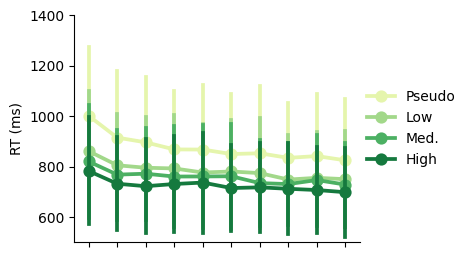

In [119]:
fig3_data = corr_trials.copy()
fig3_data['RT'] = fig3_data['RT']*1000


g = sns.catplot(
    data=fig3_data, kind="point",
    x="rep_num", y="RT", hue="wf_type",
    hue_order=('pseudo', 'lowwf', 'medwf', 'highwf'),
    errorbar="sd", palette="YlGn", alpha=1, height=3,
    aspect=1.3
)

# Setting axis labels
g.set_axis_labels("", "RT (ms)")
plt.xticks(visible=False)

# Setting ylim
plt.ylim(500, 1400)

# Modifying legend labels
g.legend.set_title("")
g._legend.texts[0].set_text('Pseudo')
g._legend.texts[1].set_text('Low')
g._legend.texts[2].set_text('Med.')
g._legend.texts[3].set_text('High')

plt.show()
g.savefig(save_dir + 'fig_4a.png', dpi=300)

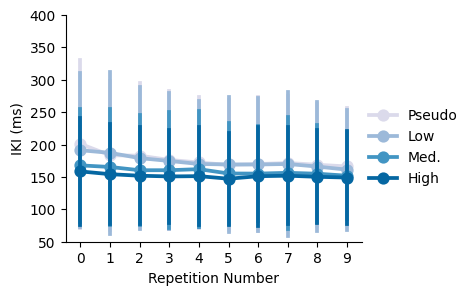

In [120]:
fig3b_data = corr_trials_bybg.copy()
fig3b_data['IKI'] = fig3b_data['IKI']*1000


g = sns.catplot(
    data=fig3b_data, kind="point",
    x="rep_num", y="IKI", hue="wf_type",
    hue_order=('pseudo', 'low', 'med', 'high'),
    errorbar="sd", palette="PuBu", alpha=1, height=3,
    aspect=1.3
)

# Setting axis labels
g.set_axis_labels("Repetition Number", "IKI (ms)")

# Setting ylim
plt.ylim(50, 400)

# Modifying legend labels
g.legend.set_title("")
g._legend.texts[0].set_text('Pseudo')
g._legend.texts[1].set_text('Low')
g._legend.texts[2].set_text('Med.')
g._legend.texts[3].set_text('High')

plt.show()
g.savefig(save_dir + 'fig_4b1.png', dpi=300)

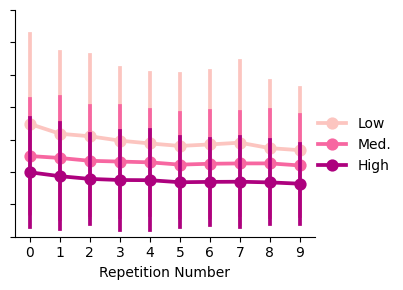

In [121]:
g = sns.catplot(
    data=fig3b_data, kind="point",
    x="rep_num", y="IKI", hue="bf_type",
    hue_order=('low', 'med', 'high'),
    errorbar="sd", palette="RdPu", alpha=1, height=3,
    aspect=1.3
)

# Setting axis labels
g.set_axis_labels("Repetition Number", "")
plt.yticks(visible=False)

# Setting ylim
plt.ylim(50, 400)

# Modifying legend labels
g.legend.set_title("")
g._legend.texts[0].set_text('Low')
g._legend.texts[1].set_text('Med.')
g._legend.texts[2].set_text('High')

plt.show()
g.savefig(save_dir + 'fig_4b2.png', dpi=300)

## Fig. 5

In [122]:
color = sns.color_palette('RdPu')[4]
print(color)
color

(0.735840061514802, 0.06196078431372548, 0.5225682429834679)


(0.735840061514802, 0.06196078431372548, 0.5225682429834679)

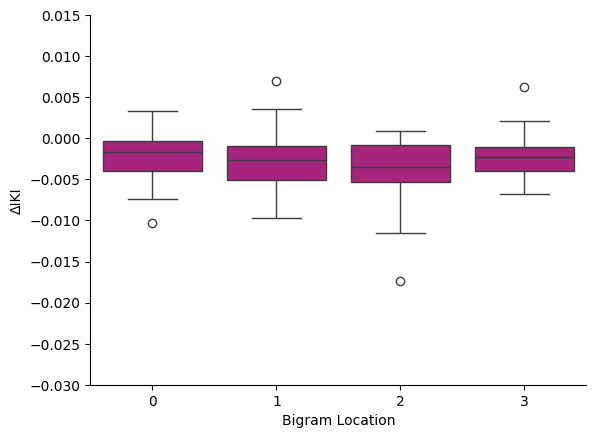

In [123]:
# Fig. 5 - delta IKI vs. bigram position
g = sns.boxplot(deltaiki_byloc, 
                   x='bigram_loc', 
                   y='delta_iki',
                   color=(0.735840061514802, 0.06196078431372548, 0.5225682429834679))
                   # edgecolor='0.25',
                   # inner='point')

sns.despine()

g.set_xlabel('Bigram Location')
g.set_ylabel('ΔIKI')

plt.ylim(-0.03, 0.015)

plt.show()
g.figure.savefig(save_dir + 'fig_5.png', dpi=300)

In [124]:
# sns.violinplot(
#                x='freq', 
#                y='value', 
#                hue='freq', 
#                hue_order=hue_order, 
#                palette=palette, 
#                ax=ax,
#                edgecolor='0.25',
#                inner='point'
# )

# Paper Tables

In [125]:
# Makes table of all individual speed and variability IKI metrics
all_ikimetrics = pd.concat([all_bybf, 
                            all_bywf,
                            all_deltas_bybf,
                            all_deltas_bywf,
                            all_totaldeltas_bybf,
                            all_errors_bybf,
                            all_errors_bywf,
                            all_totaldeltas_bywf,
                            rt_bywf,
                            all_deltarts_bywf]).reset_index(drop=True)

# Calculates frequency category means and SDs and collects into dataframe
table_dict = {}

for freq_type in ['wf_type', 'bf_type']:
    for freq in all_ikimetrics[freq_type].unique():
        if pd.isna(freq) == False:
            col_list = ['mean_IKI', 'sd_IKI', 'cv_IKI',
                        'mean_deltaiki',
                        'total_error',
                        'mean_RT', 'sd_RT', 'cv_RT',
                        'mean_deltart']
            value_list = []
            for col in col_list:
                metric_mean = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].mean(numeric_only=True)
                metric_sd = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].std(numeric_only=True)
                if col in ['mean_IKI', 'sd_IKI']:
                    mean_3sig = f"{(metric_mean):.3g}"
                    sd_3sig = f"{(metric_sd):.3g}"
                    value_list.append(("{} ± {}").format(mean_3sig, sd_3sig))
                elif col in ['mean_RT', 'sd_RT']:
                    mean_3sig = f"{(metric_mean*1000):.3g}"
                    sd_3sig = f"{(metric_sd*1000):.3g}"
                    value_list.append(("{} ± {}").format(mean_3sig, sd_3sig))
                elif col in ['mean_deltaiki', 'mean_deltart']:
                    mean_2sig = f"{(metric_mean*1000):.2g}"
                    sd_2sig = f"{(metric_sd*1000):.2g}"
                    value_list.append(("{} ± {}").format(mean_2sig, sd_2sig))
                elif col in ['cv_IKI', 'cv_RT', 'total_error']:
                    mean_2sig = f"{(metric_mean):.2g}"
                    sd_2sig = f"{(metric_sd):.2g}"
                    value_list.append(("{} ± {}").format(mean_2sig, sd_2sig))
            table_dict[("{}_{}").format(freq_type,freq)] = value_list

table_dict
paper_table = pd.DataFrame().from_dict(table_dict)
metric_names = ['Mean IKI (ms)',
                'SD IKI (ms)',
                'CV IKI',
                'Mean ΔIKI (ms)',
                'Total Error',
                'Mean RT (ms)',
                'SD RT (ms)',
                'CV RT',
                'Mean ΔRT (ms)']
paper_table.insert(0, 'Metric', metric_names)
paper_table = paper_table.replace('nan ± nan', None)
paper_table.to_csv(save_dir + '/papertable1.csv')
paper_table

Metric       wf_type_pseudo          wf_type_low  \
0   Mean IKI (ms)           176 ± 43.3           174 ± 39.5   
1     SD IKI (ms)          93.1 ± 32.6          96.6 ± 30.4   
2          CV IKI         0.52 ± 0.099          0.55 ± 0.11   
3  Mean ΔIKI (ms)           -4.1 ± 4.5           -4.1 ± 3.5   
4     Total Error                 None                 None   
5    Mean RT (ms)   8.79e+05 ± 1.8e+05  7.88e+05 ± 1.45e+05   
6      SD RT (ms)  1.76e+05 ± 6.03e+04  1.38e+05 ± 5.87e+04   
7           CV RT          0.2 ± 0.051         0.17 ± 0.055   
8   Mean ΔRT (ms)             -21 ± 16             -16 ± 13   

           wf_type_med         wf_type_high   bf_type_low   bf_type_med  \
0           160 ± 35.4           152 ± 35.3    198 ± 44.9    166 ± 35.3   
1          70.6 ± 28.2          63.6 ± 20.4    105 ± 32.1   73.1 ± 24.8   
2          0.43 ± 0.12         0.42 ± 0.088  0.53 ± 0.089  0.44 ± 0.093   
3           -2.1 ± 2.4          -0.98 ± 2.2    -5.1 ± 3.8    -1.9 ± 2.6   
4                 None                 None          None          None   
5    7.6e+05 ± 1.3e+05  7.28e+05 ± 1.36e+05          None          None   
6  1.34e+05 ± 5.48e+04  1.21e+05 ± 5.33e+04          None          None   
7         0.17 ± 0.055         0.16 ± 0.053          None          None   
8            -9.6 ± 11            -7.8 ± 13          None          None   

  bf_type_high  
0   138 ± 35.2  
1  60.4 ± 23.2  
2  0.43 ± 0.11  
3   -1.9 ± 2.9  
4         None  
5         None  
6         None  
7         None  
8         None

In [126]:
# Creating table of values and exporting as .png
gt_df = paper_table
gt_df
col_names = ['bf_type_low',
             'bf_type_med',
             'bf_type_high',
             'wf_type_low',
             'wf_type_med',
             'wf_type_high',
             'wf_type_pseudo']
gt_papertable = (
    GT(gt_df)
    .tab_header(
        title = 'Group Averages and Standard Deviations for Collected Metrics'
    )
    .tab_spanner(label='Bigram Frequency', columns=['bf_type_low',
                                                    'bf_type_med',
                                                    'bf_type_high'])
    .tab_spanner(label='Word Frequency', columns=['wf_type_pseudo',
                                                  'wf_type_low',
                                                  'wf_type_med',
                                                  'wf_type_high'])
    .cols_label(
        bf_type_low = 'Low',
        bf_type_med = 'Medium',
        bf_type_high = 'High',
        wf_type_pseudo = 'Pseudo',
        wf_type_low = 'Low',
        wf_type_med = 'Medium',
        wf_type_high = 'High'
    )
    .tab_stub(rowname_col='Metric')
    .tab_stubhead(label='Metric')
    .sub_missing(
        columns=['bf_type_low', 'bf_type_med', 'bf_type_high'],
        missing_text="-"
    )
)

GT.save(gt_papertable, save_dir + '/paper_table.png', window_size=(7000, 7000))
gt_papertable

Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event)


GT(_tbl_data=           Metric       wf_type_pseudo          wf_type_low  \
0   Mean IKI (ms)           176 ± 43.3           174 ± 39.5   
1     SD IKI (ms)          93.1 ± 32.6          96.6 ± 30.4   
2          CV IKI         0.52 ± 0.099          0.55 ± 0.11   
3  Mean ΔIKI (ms)           -4.1 ± 4.5           -4.1 ± 3.5   
4     Total Error                 None                 None   
5    Mean RT (ms)   8.79e+05 ± 1.8e+05  7.88e+05 ± 1.45e+05   
6      SD RT (ms)  1.76e+05 ± 6.03e+04  1.38e+05 ± 5.87e+04   
7           CV RT          0.2 ± 0.051         0.17 ± 0.055   
8   Mean ΔRT (ms)             -21 ± 16             -16 ± 13   

           wf_type_med         wf_type_high   bf_type_low   bf_type_med  \
0           160 ± 35.4           152 ± 35.3    198 ± 44.9    166 ± 35.3   
1          70.6 ± 28.2          63.6 ± 20.4    105 ± 32.1   73.1 ± 24.8   
2          0.43 ± 0.12         0.42 ± 0.088  0.53 ± 0.089  0.44 ± 0.093   
3           -2.1 ± 2.4          -0.98 ± 2.2    -5.1 ± 3.8    -1.9 ± 2.6   
4                 None                 None          None          None   
5    7.6e+05 ± 1.3e+05  7.28e+05 ± 1.36e+05          None          None   
6  1.34e+05 ± 5.48e+04  1.21e+05 ± 5.33e+04          None          None   
7         0.17 ± 0.055         0.16 ± 0.053          None          None   
8            -9.6 ± 11            -7.8 ± 13          None          None   

  bf_type_high  
0   138 ± 35.2  
1  60.4 ± 23.2  
2  0.43 ± 0.11  
3   -1.9 ± 2.9  
4         None  
5         None  
6         None  
7         None  
8         None  , _body=<great_tables._gt_data.Body object at 0x284ea53a0>, _boxhead=Boxhead([ColInfo(var='Metric', type=<ColInfoTypeEnum.stub: 2>, column_label='Metric', column_align='left', column_width=None), ColInfo(var='wf_type_pseudo', type=<ColInfoTypeEnum.default: 1>, column_label='Pseudo', column_align='left', column_width=None), ColInfo(var='wf_type_low', type=<ColInfoTypeEnum.default: 1>, column_label='Low', column_align='left', column_width=None), ColInfo(var='wf_type_med', type=<ColInfoTypeEnum.default: 1>, column_label='Medium', column_align='left', column_width=None), ColInfo(var='wf_type_high', type=<ColInfoTypeEnum.default: 1>, column_label='High', column_align='left', column_width=None), ColInfo(var='bf_type_low', type=<ColInfoTypeEnum.default: 1>, column_label='Low', column_align='left', column_width=None), ColInfo(var='bf_type_med', type=<ColInfoTypeEnum.default: 1>, column_label='Medium', column_align='left', column_width=None), ColInfo(var='bf_type_high', type=<ColInfoTypeEnum.default: 1>, column_label='High', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x284ee76e0>, _spanners=Spanners([SpannerInfo(spanner_id='Bigram Frequency', spanner_level=0, spanner_label='Bigram Frequency', spanner_units=None, spanner_pattern=None, vars=['bf_type_low', 'bf_type_med', 'bf_type_high'], built=None), SpannerInfo(spanner_id='Word Frequency', spanner_level=0, spanner_label='Word Frequency', spanner_units=None, spanner_pattern=None, vars=['wf_type_pseudo', 'wf_type_low', 'wf_type_med', 'wf_type_high'], built=None)]), _heading=Heading(title='Group Averages and Standard Deviations for Collected Metrics', subtitle=None, preheader=None), _stubhead='Metric', _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x284d35dc0>, _formats=[], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x177e436b0>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_

# Exporting DataFrames

In [127]:
# os.chdir(save_dir)
# all_ikimetrics.to_csv('metric_means_all.csv')
# all_ikimetrics

# test = pd.concat([all_bybf, 
#                 all_bywf,
#                 all_deltas_bybf,
#                 all_deltas_bywf,
#                 all_totaldeltas_bybf,
#                 all_errors_bybf,
#                 all_errors_bywf,
#                 all_totaldeltas_bywf,
#                 rt_bywf,
#                 all_deltarts_bywf],
#                 verify_integrity=True,
#                 ignore_index=True,
#                 axis=1).reset_index(drop=True)

os.chdir(save_dir)

dfs = {
    'iki_metrics_bybf': all_bybf,
    'iki_metrics_bywf': all_bywf,
    'delta_ikis_bybf': all_deltas_bybf,
    'delta_ikis_bywf': all_deltas_bywf,
    'rts_bywf': rt_bywf,
    'delta_rts_bywf': all_deltarts_bywf
}

# Iterate through the dictionary of DataFrames
for name, df in dfs.items():
    # Create the file name using the DataFrame name
    df.to_csv('{}.csv'.format(name))

# Graveyard
___

# MRS Correlation
___

In [128]:
## importing GABA quanitification .csv
## data table is edited to exclude certain data point prior to import
GABA_quant = pd.read_csv(r'/Volumes/greenhouse/MRS/data/Typ_GABA_quant_filtered.csv')
GABA_quant_nofilt = pd.read_csv(r'/Volumes/greenhouse/MRS/data/Typ_GABA_quant.csv')
GABA_sIDs = GABA_quant.sID.unique() ## making list of sIDs with GABA data

In [129]:
def GABA_ID_filter(df):
    filtered = df[df.sID.isin(GABA_sIDs)]
    filtered = filtered.sort_values(by='sID', ascending=True).reset_index(drop=True)
    return filtered

GABA_ID_filter(all_bybf)
# 19*3

sID    mean_IKI      sd_IKI    cv_IKI bf_type
0   s009  171.185076   79.097434  0.461205     low
1   s009  121.015286   50.519587  0.416852     med
2   s009  100.649571   51.247410  0.508360    high
3   s020  220.205491  139.030985  0.630007     low
4   s020  184.398401   81.480119  0.441170     med
..   ...         ...         ...       ...     ...
58  s348  207.332800  118.575951  0.570831     low
59  s348  181.831618   87.083031  0.478170     med
60  s350  185.224783  104.706724  0.564236     low
61  s350  151.605886   53.662994  0.353438     med
62  s350  118.296956   50.689109  0.427839    high

[63 rows x 5 columns]

In [130]:
## filtering corr_bgs to only have subjects with GABA data


# GABA_corr_bgs = corr_bgs[corr_bgs.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
# GABA_corr_trials = corr_trials[corr_trials.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
# GABA_mean_rts = rt_bywf[rt_bywf.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
# GABA_deltaiki = all_deltarts_bywf[all_deltarts_bywf.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
# # allmean_GABA_totaldeltaiki = pd.DataFrame(GABA_totaldeltaiki.groupby('sID').mean_totaldeltaiki.agg('mean')).reset_index()



In [131]:
## calculating mean and sd iki across all bigram categories for GABA subjects only  
# GABA_means = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'all_mean_iki'})
# GABA_sds = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['std'])).reset_index().rename(columns = {'std':'all_sd_iki'})

In [132]:
## making filtered dataframes for the voxels of interest
# GABA_Rthal = GABA_df[(GABA_df.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)
# GABA_Lthal = GABA_df[(GABA_df.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)
# GABA_RLthal = pd.concat([GABA_Rthal, GABA_Lthal])

# GABA_RM1 = GABA_df[(GABA_df.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)
# GABA_LM1 = GABA_df[(GABA_df.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)
# GABA_RLM1 = pd.concat([GABA_RM1, GABA_LM1])

# # l_voxs = pd.concat([GABA_Lthal, GABA_LM1]).reset_index(drop=True)
# # r_voxs = pd.concat([GABA_Rthal, GABA_RM1]).reset_index(drop=True)

In [133]:
GABA_quant_nofilt.groupby('voxel').mean(numeric_only=True).reset_index()

voxel  A1_GABA_Cr  A2_GABA_Cr  Mean_GABA_Cr     A1_FE      A2_FE  \
0    L_M1    0.111748    0.111345      0.111546  4.440296   4.277285   
1  L_thal   -0.208897    0.122874     -0.043012  6.391685   7.882581   
2    R_M1    0.114297    0.116519      0.115408  4.552469   4.282499   
3  R_thal  -19.638197    0.097678     -9.770259  7.226292  13.071063   
4     occ    0.110867    0.110149      0.110508  3.228397   3.282386   

     Mean_FE  
0   4.358791  
1   7.137133  
2   4.417484  
3  10.148677  
4   3.255391

In [134]:
A1_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
A2_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
both_meanGABA = GABA_quant_nofilt.groupby(['voxel']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
A1_FE = GABA_quant_nofilt.groupby(['voxel']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
A2_FE = GABA_quant_nofilt.groupby(['voxel']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
both_FE = GABA_quant_nofilt.groupby(['voxel']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

by_voxel = pd.concat([A1_meanGABA, 
                      A2_meanGABA['A2_meanGABA'], 
                      both_meanGABA['both_meanGABA'], 
                      A1_FE['A1_meanFE'], 
                      A2_FE['A2_meanFE'], 
                      both_FE['both_meanFE']], 
                      axis = 1)

L_thal_shims = {'A1_shims' : [17.6, 21.5, 19, 29, 17.4, 16.9, 20.6, 23.4, 22, 19.9], 
                'A2_ shims' : [float('nan'), 21.2, 18.8, 28.9, float('nan'), 16.8, 21.4, 22.4, 22, 20]}
Lthal_shims = pd.DataFrame(L_thal_shims).reset_index(drop = True)

only_Lthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'L_thal'].reset_index(drop = True)
only_Lthal = pd.concat([only_Lthal, Lthal_shims], axis = 1)
only_Lthal = only_Lthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')


R_thal_shims = {'A1_shims' : [18.9, 21.7, 18.3, 30.2, 18.1, 17.8, 19.1, 20.1, 24.3, 21.5],
                'A2_ shims' : [float('nan'), 20.7, 18.4, 31.2, float('nan'), 17.7, 19.8, 19.8, 23.1, 22]}
Rthal_shims = pd.DataFrame(R_thal_shims).reset_index(drop = True)
only_Rthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'R_thal'].reset_index(drop = True)
only_Rthal = pd.concat([only_Rthal, Rthal_shims], axis = 1)
only_Rthal = only_Rthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')

only_Rthal

# A1_meanGABA = only_thal.groupby(['sID']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
# A2_meanGABA = only_thal.groupby(['sID']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
# both_meanGABA = only_thal.groupby(['sID']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
# A1_FE = GABA_quant_nofilt.groupby(['sID']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
# A2_FE = GABA_quant_nofilt.groupby(['sID']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
# both_FE = GABA_quant_nofilt.groupby(['sID']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

# by_sID = pd.concat([A1_meanGABA, 
#                       A2_meanGABA['A2_meanGABA'], 
#                       both_meanGABA['both_meanGABA'], 
#                       A1_FE['A1_meanFE'], 
#                       A2_FE['A2_meanFE'], 
#                       both_FE['both_meanFE']], 
#                      axis = 1)

rt_bywf

sID      mean_RT       sd_RT     cv_RT wf_type
0    s009   673.829627   70.665989  0.103995  pseudo
1    s020  1238.065852  253.408342  0.202703  pseudo
2    s175   869.944190   98.793918  0.112399  pseudo
3    s176   961.535158  136.876050  0.141097  pseudo
4    s178   860.411068  144.419010  0.166316  pseudo
..    ...          ...         ...       ...     ...
183  s348   697.468424   67.648244  0.096089    high
184  s349   732.000879  102.792867  0.139070    high
185  s350   630.373995   86.769992  0.136477    high
186  s351   706.632311  146.881452  0.205963    high
187  s352   547.114488   80.402546  0.145538    high

[188 rows x 5 columns]

In [135]:
GABA_df = pd.concat([GABA_quant,
                     GABA_ID_filter(all_bybf),
                     GABA_ID_filter(all_bywf),
                     GABA_ID_filter(rt_bywf),
                     GABA_ID_filter(all_deltarts_bywf),
                     GABA_ID_filter(all_deltas_bybf),
                     GABA_ID_filter(all_deltas_bywf)],
                     axis=1).reset_index(drop=True)

GABA_df

sID   voxel  A1_GABA_Cr  A2_GABA_Cr  Mean_GABA_Cr     A1_FE     A2_FE  \
0    s009    L_M1    0.123000    0.103333      0.113166  3.666177  6.027108   
1    s009  L_thal         NaN         NaN           NaN       NaN       NaN   
2    s009     occ    0.110393    0.098018      0.104206  2.861759  4.184033   
3    s009    R_M1    0.113744    0.118672      0.116208  4.764988  4.222443   
4    s009  R_thal         NaN         NaN           NaN       NaN       NaN   
..    ...     ...         ...         ...           ...       ...       ...   
99   s350  R_thal    0.105057    0.100070      0.102563  5.199043  4.188527   
100  s350  L_thal    0.104738    0.078320      0.091529  9.584373  9.212279   
101  s350    L_M1    0.107305    0.104637      0.105971  3.881868  4.365238   
102  s350    R_M1    0.148775    0.118406      0.133591  5.793407  4.785378   
103  s350     occ    0.119822    0.117537      0.118679  2.933242  2.900027   

      Mean_FE   sID    mean_IKI  ...  mean_deltart  wf_type  index   sID  \
0    4.846642  s009  171.185076  ...     -0.016145   pseudo    0.0  s009   
1         NaN  s009  121.015286  ...     -0.014348      med    0.0  s009   
2    3.522896  s009  100.649571  ...     -0.010715      low    0.0  s009   
3    4.493716  s020  220.205491  ...     -0.010060     high    1.0  s020   
4         NaN  s020  184.398401  ...     -0.022324      low    1.0  s020   
..        ...   ...         ...  ...           ...      ...    ...   ...   
99   4.693785   NaN         NaN  ...           NaN      NaN    NaN   NaN   
100  9.398326   NaN         NaN  ...           NaN      NaN    NaN   NaN   
101  4.123553   NaN         NaN  ...           NaN      NaN    NaN   NaN   
102  5.289392   NaN         NaN  ...           NaN      NaN    NaN   NaN   
103  2.916635   NaN         NaN  ...           NaN      NaN    NaN   NaN   

    mean_deltaiki  bf_type  index   sID mean_deltaiki  wf_type  
0       -0.005433      low    0.0  s009     -0.003556   pseudo  
1       -0.002871      med    0.0  s009     -0.002700      med  
2        0.000018     high    0.0  s009     -0.001616      low  
3       -0.001539      low    0.0  s009     -0.002630     high  
4        0.000377      med    1.0  s020      0.000021      low  
..            ...      ...    ...   ...           ...      ...  
99            NaN      NaN    NaN   NaN           NaN      NaN  
100           NaN      NaN    NaN   NaN           NaN      NaN  
101           NaN      NaN    NaN   NaN           NaN      NaN  
102           NaN      NaN    NaN   NaN           NaN      NaN  
103           NaN      NaN    NaN   NaN           NaN      NaN  

[104 rows x 34 columns]

In [136]:
## making summary df with all relevant info
GABA_df = pd.concat([pd.DataFrame(GABA_sIDs),
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'lowbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'medbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'highbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg IKI'],
                     GABA_means['all_mean_iki'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'lowbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'medbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'highbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg SD IKI'],
                     GABA_sds['all_sd_iki'],
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'pseudo']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'lowwf']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'medwf']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'medwf']['mean_RT'].reset_index(drop=True),
                     indiv_meandeltaod(GABA_corr_trials, typ.pseudo)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.lowwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.medwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.highwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, list(typ.all_bigrams))['mean_deltaod'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.pseudo)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.lowwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.medwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.highwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', list(typ.all_bigrams))['mean_deltaiki'],
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'pseudo']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'low']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'med']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'high']['mean_totaldeltaiki'].reset_index(drop=True),
                     allmean_GABA_totaldeltaiki['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_quant[(GABA_quant.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr']],
                     axis=1).reset_index(drop=True)

labels = ['sID', 
          'low_mean_iki',
          'med_mean_iki',
          'high_mean_iki',
          'all_avg_mean_iki',
          'all_mean_iki',
          'low_sd_iki', 
          'med_sd_iki', 
          'high_sd_iki', 
          'all_avg_sd_iki',
          'all_sd_iki',
          'pseudo_od',
          'low_od',
          'med_od',
          'high_od',
          'pseudo_deltaod',
          'low_deltaod',
          'med_deltaod',
          'high_deltaod',
          'all_deltaod',
          'pseudo_deltaiki',
          'low_deltaiki',
          'med_deltaiki',
          'high_deltaiki',
          'all_deltaiki',
          'pseudo_totaldeltaiki',
          'low_totaldeltaiki',
          'med_totaldeltaiki',
          'high_totaldeltaiki',
          'all_totaldeltaiki',
          'R_thal_GABA', 
          'L_thal_GABA', 
          'R_M1_GABA', 
          'L_M1_GABA']
GABA_df.columns = labels

## adding column with difference between low and high sd iki
GABA_df['delta_sd_iki'] = GABA_df['low_sd_iki'] - GABA_df['high_sd_iki']
# GABA_df = GABA_df.drop(list(range(10,17)))
GABA_df

# print(np.std(GABA_df.low_sd_iki))
# print(np.std(GABA_df.med_sd_iki))
# print(np.std(GABA_df.high_sd_iki))

NameError: name 'GABA_corr_bgs' is not defined

In [ ]:
## testing if thalamus and M1 GABA are significantly different -- fix later, but they aren't
# meanRL_thal = (GABA_Rthal['Mean_GABA_Cr'] + GABA_Lthal['Mean_GABA_Cr'])/2
# meanRL_thal = pd.concat([GABA_Lthal['sID'], meanRL_thal], axis = 1)

# meanRL_M1 = (GABA_RM1['Mean_GABA_Cr'] + GABA_LM1['Mean_GABA_Cr'])/2
# meanRL_M1 = pd.concat([GABA_LM1['sID'], meanRL_M1], axis = 1)

# no_match = ~np.logical_or(np.isnan(meanRL_thal['Mean_GABA_Cr']), np.isnan(meanRL_M1['Mean_GABA_Cr']))

# meanRL_M1_match = meanRL_M1[no_match]
# meanRL_thal_match = meanRL_thal[no_match]

# stats.ttest_rel(meanRL_thal_match['Mean_GABA_Cr'], meanRL_M1_match['Mean_GABA_Cr'])

In [ ]:
## making dataframes that are matched such that a paticipant will be excluded if they don't have data from both L and R thal voxels
# bad = ~np.logical_or(np.isnan(GABA_Rthal['Mean_GABA_Cr']), np.isnan(GABA_Lthal['Mean_GABA_Cr']))

# GABA_Lthal_match = GABA_Lthal[bad]
# GABA_Rthal_match = GABA_Rthal[bad]

# print(pearsonr(GABA_Lthal_match['Mean_GABA_Cr'], GABA_Rthal_match['Mean_GABA_Cr'])) ## comparing L and R thal GABA
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])) ## comparing L and R M1 GABA


### FIX LATER

In [ ]:
# print('L vs R thal')
# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'], GABA_Rthal['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

# print('L vs R M1')
# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

In [ ]:
# creating lists of sIDs that have data for each category
Rthal_sIDs = GABA_df[~np.isnan(GABA_df.R_thal_GABA)].sID.unique()
Lthal_sIDs = GABA_df[~np.isnan(GABA_df.L_thal_GABA)].sID.unique()

In [ ]:
## thal comparisons
# print('GABA correlated against low bf sds')
# # temp = indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')
# R_lowbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_lowbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_lowbf_sds = pd.concat([R_lowbf_sds, L_lowbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# temp = indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')
# R_highbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_highbf_sds = pd.concat([R_highbf_sds, L_highbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_highbf_sds['Avg SD IKI']))

print('GABA correlated against all bf sds')
R_allbf_sds = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_sd_iki']
L_allbf_sds = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_sd_iki']
print(pearsonr(R_allbf_sds, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_sds, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
R_allbf_means = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_mean_iki']
L_allbf_means = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_mean_iki']
print(pearsonr(R_allbf_means, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_means, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against delta sd iki')
R_delta_sd = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['delta_sd_iki']
L_delta_sd = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['delta_sd_iki']
print(pearsonr(R_delta_sd, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_delta_sd, GABA_df.L_thal_GABA.dropna()))

# print('GABA correlated against low bf cvs')
# temp = indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')
# R_lowbf_cvs = temp[temp.sID.isin(Rthal_sIDs)]
# L_lowbf_cvs = temp[temp.sID.isin(Lthal_sIDs)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI']))

# print('GABA correlated against high bf cvs')
# temp = indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')
# R_highbf_cvs = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_cvs = temp[temp.sID.isin(Lthal_sIDS)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI']))

In [ ]:
GABA_df.pseudo_totaldeltaiki

In [ ]:
## M1 comparisons
# print('GABA correlated against low bf sds')
# print(pearsonr(GABA_RM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against high bf cvs')
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against low bf cvs')
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

print('GABA correlated against all bf sds')
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo od')
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high od')
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta od')
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta od')
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta od')
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta iki')
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta iki')
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta iki')
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo total delta iki')
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high total delta iki')
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all total delta iki')
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

In [ ]:
## lowbf cvs against L_thal GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI'])
# # plt.xlim([0.1, 0.13])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("lowbf cvs against L_thal GABA")

# plt.show()

In [ ]:
## lowbf cvs against L_M1 GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_cvs['Avg CV IKI'])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("")

# plt.show()

In [ ]:
## highbf cvs against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'Lthal_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf cvs against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'LM1_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'Lthal_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'LM1_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
R_allbf_means

In [ ]:
GABA_df.L_thal_GABA.dropna()

In [ ]:
## all bf mean IKIs against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_means, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_means, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI (all Bigram Freqs.)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf mean IKIs against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf sds against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_sds, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_sds, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (all BFs)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## all bf sds against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

plt.legend(fontsize = '17',loc="lower left", facecolor = 'black')

plt.savefig(save_dir + 'RLM1_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## highbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'Lthal_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# # plt.xlim([0.1, 0.12])
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'LM1_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## all delta ods against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ Onset Delay (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaod.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all total delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Total Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## Graphs for F31

In [ ]:
ten_sub_list = ['s181', 's182', 's183', 's189', 's190', 
           's198', 's207', 's209', 's210', 's212']

ten_sub = corr_trials_bybg[corr_trials_bybg.sID.isin(ten_sub_list)].reset_index()

In [ ]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_meanikis(ten_sub, 'bigram', 'lowbf')['Avg IKI'], 
     indiv_meanikis(ten_sub, 'bigram', 'medbf')['Avg IKI'],
     indiv_meanikis(ten_sub, 'bigram', 'highbf')['Avg IKI'])
means = (np.mean(indiv_meanikis(ten_sub, 'bigram', 'lowbf')['Avg IKI']),
         np.mean(indiv_meanikis(ten_sub, 'bigram', 'medbf')['Avg IKI']),
         np.mean(indiv_meanikis(ten_sub, 'bigram', 'highbf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.4])
plt.xticks(x, ('', '', ''), fontsize = 24)
plt.xticks(x, ('Low', 'Med', 'High'))
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'F31_indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_cvikis(ten_sub, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(ten_sub, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(ten_sub, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(ten_sub, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(ten_sub, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(ten_sub, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.10, 0.4])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean CV IKI (%)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'F31_indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_sdikis(ten_sub, 'bigram', 'lowbf')['Avg SD IKI'], 
     indiv_sdikis(ten_sub, 'bigram', 'medbf')['Avg SD IKI'],
     indiv_sdikis(ten_sub, 'bigram', 'highbf')['Avg SD IKI'])
means = (np.mean(indiv_sdikis(ten_sub, 'bigram', 'lowbf')['Avg SD IKI']), 
         np.mean(indiv_sdikis(ten_sub, 'bigram', 'medbf')['Avg SD IKI']),
         np.mean(indiv_sdikis(ten_sub, 'bigram', 'highbf')['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.0, 0.10])
plt.xticks(x, ('', '', ''), fontsize = 24)
# plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
# plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean SD IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'F31_indiv_sdikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
incorr_ten_sub = incorr_bgs[incorr_bgs.sID.isin(ten_sub_list)].reset_index()

plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_ten_sub, 'bigram', 'lowbf')['Total Error'], 
     indiv_error(incorr_ten_sub, 'bigram', 'medbf')['Total Error'],
     indiv_error(incorr_ten_sub, 'bigram', 'highbf')['Total Error'])

means = (np.mean(indiv_error(incorr_ten_sub, 'bigram', 'lowbf')['Total Error']), 
         np.mean(indiv_error(incorr_ten_sub, 'bigram', 'medbf')['Total Error']),
         np.mean(indiv_error(incorr_ten_sub, 'bigram', 'highbf')['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-1, 22])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Indiv. Total Error", labelpad=15, fontsize = 24)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'F31_meanerr_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

violin = ax.violinplot(D, [2, 4, 6], showmeans= True)

for pc in violin["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# boxprops = dict(linestyle='-', linewidth=2, color = 'black')
# whiskerprops = dict(linewidth=2, color = 'black')
# capprops = dict(linewidth=2, color = 'black')
# flierprops = dict(markerfacecolor='royalblue', markersize=10)
# medianprops = dict(linewidth=2, color='red')

# ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
#           flierprops=flierprops, medianprops=medianprops)


plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.yaxis.offsetText.set_fontsize(18)
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'F31_bf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

In [ ]:
## anova for sds (by bg freq)
high_sd = indiv_sdikis(ten_sub, 'bigram', 'highbf')
high_sd['bf_type'] = 'high'
med_sd = indiv_sdikis(ten_sub, 'bigram', 'medbf_norep')
med_sd['bf_type'] = 'med'
low_sd = indiv_sdikis(ten_sub, 'bigram', 'lowbf_norep')
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

# GRAPHS
___

## Data Visualization
___

In [ ]:
## bigram frequency distribution
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(typ.bg_freqs['Bigrams'], typ.bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(all_bigrams['bg_freq'], all_bigrams['IKI'])

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## Histogram of bigram frequencies
plt.figure(figsize=(50, 10))
bg_freq = plt.hist(all_bigrams['bg_freq'], bins = 100)

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
# bg_freq = plt.scatter(all_bigrams[all_bigrams.sID == 's175']['bg_freq'], all_bigrams[all_bigrams.sID == 's175']['IKI'])

# sns.scatterplot(data = all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')], 
#                x = 'bg_freq', y = 'IKI')
    
    
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['IKI'], c='r')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['IKI'], c='b')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['IKI'], c='g')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['IKI'], c='k')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['IKI'], c='m')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['IKI'], c='y')

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")
plt.ylim([0, 0.25])

plt.show()

In [ ]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [ ]:
## plot showing distribution of bigram frequency types across each position in the string
locs = [0, 1, 2, 3]
type_list = ['high', 'med', 'low']
        
high = [6, 8, 7, 7]
med = [10, 8, 9, 8]
low = [8, 8, 8, 9]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high, width=width, 
        color='b', label='high bf')
plt.bar(indices, med, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks([0, 1, 2, 3])
plt.xlabel("IKI position")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

In [ ]:
## number of bigrams in each freq. type across word freq. categories
for wf_type in wf_groups:
    bf_in_wf = 0
    wf = getattr(typ, wf_type)
    for bf_type in bf_groups:
        bf = getattr(typ, bf_type)
        for bigram in bf:
            for string in wf:
                if bigram in string:
                    bf_in_wf = bf_in_wf + 1
        print(bf_in_wf, bf_type, 'in', wf_type)

In [ ]:
## number of bigrams in each freq. type across word freq. categories
locs = [0, 1, 2, 3]
type_list = ['high_bf', 'med_bf', 'low_bf']
        
high_bf = [24, 24, 24, 24]
med_bf = [16, 14, 18, 15]
low_bf = [12, 6, 5, 5]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high_bf, width=width, 
        color='b', label='high bf')
plt.bar(indices, med_bf, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low_bf, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks(locs, ['pseudo', 'low', 'med', 'high'])
plt.xlabel("WF")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

In [ ]:
typ.bg_freqs[typ.bg_freqs['Bigrams'].isin(typ.lowbf)]

## BG FREQ GRAPHS
___

In [ ]:
## plotting BF distribution of data set
high_bgs = typ.bg_freqs.loc[0:15]
med_bgs = typ.bg_freqs.loc[15:46]
low_bgs = typ.bg_freqs.loc[46:69]

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'bf.png', dpi=300)
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'black')
whiskerprops = dict(linewidth=2, color = 'black')
capprops = dict(linewidth=2, color = 'black')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'wf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## Bigram-Word Interaction
___

In [ ]:
## prints number of repetitions of each bigram within the string bank
rep_df = pd.DataFrame()
for bigram in typ.all_bigrams:
    rep_num = 0
    for string in typ.all_strings:
        if bigram in string:
            rep_num = rep_num + 1
    # print(bigram, rep_num)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'edthe' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("cornflowerblue")
    pc.set_edgecolor("cornflowerblue")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('he', 'eo', 'on', 'nd'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig(save_dir + 'heond_dist.png', dpi=300, transparent = True)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'think' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("tomato")
    pc.set_edgecolor("tomato")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'hi', 'in', 'nk'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig(save_dir + 'think_dist.png', dpi=300, transparent = True)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'theme' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("goldenrod")
    pc.set_edgecolor("goldenrod")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'he', 'em', 'me'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig(save_dir + 'theme_dist.png', dpi=300, transparent = True)

In [ ]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, one individual)    
strings_with_onesub = pd.DataFrame()
for string in typ.all_strings:
    bigram = 'th' ## edit bigram of interest here
    if bigram in string:
         strings_with_onesub[string] = corr_trials_bybg[(corr_trials_bybg.sID == 's180') ## edit sID here 
                                              & (corr_trials_bybg.bigram == bigram) 
                                              & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
strings_with_onesub

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with_onesub)

In [ ]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()

for string in typ.all_strings:
        bigram = 'he' ## edit bigram of interest here
        if bigram in string:
                temp = corr_trials_bybg[(corr_trials_bybg.bigram == bigram) 
                                        & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
                strings_with[string] = temp

strings_with

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with)

In [ ]:
## distribution of a bigram's ~INDIVIDUAL MEAN~ IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()
for index, ID in enumerate(ID_list):
    strings_with.loc[index, 'sID'] = ID
    for string in typ.all_strings:
        bigram = 're' ## edit bigram of interest here
        if bigram in string:
             strings_with.loc[index, string] = corr_trials_bybg[(corr_trials_bybg.sID == ID) 
                                                  & (corr_trials_bybg.bigram == bigram) 
                                                  & (corr_trials_bybg.string == string)]['IKI'].mean()

strings_with

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with)

In [ ]:
string = 'heond' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
fig, ax = plt.subplots()
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='tab20', ax=ax).set(title = string)
ax.set_ylim(-0.02,1)
plt.show()

In [ ]:
## plot showing iki distributions for bigrams in each word (correct trials, all individuals)
fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)
#axs.set_ylim([0,2])

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[corr_trials.string == string]
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sns.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])
        

In [ ]:
## plot showing iki distributions for bigrams in each word for one participant (correct trials)

fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[(corr_trials.string == string)
                        & (corr_trials.sID == 's175')] ## change ID here
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sns.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])

In [ ]:
def wf_order_effects(bigram, first_wf, second_wf):
    b2b = pd.DataFrame()
    for sID in ID_list:
        DF = pd.DataFrame(corr_trials_bybg[(corr_trials_bybg['sID'] == sID) 
                          & (corr_trials_bybg['bigram'] == bigram)]).reset_index(drop=True)
        for index, data in enumerate(DF):
            if DF.loc[index, 'trial_num'] == DF.loc[index+1, 'trial_num'] - 1:
                if DF.loc[index, 'wf_type'] == first_wf and DF.loc[index+1, 'wf_type'] == second_wf:
                    # temp1 = pd.DataFrame(DF.loc[index]).T.reset_index(drop = True)
                    temp2 = pd.DataFrame(DF.loc[index+1]).T.reset_index(drop = True)
                    b2b = pd.concat([b2b, temp2])
    return b2b

In [ ]:
wf_order_effects('th', 'high', 'pseudo')

In [ ]:
def b2b_diff(wf1, wf2):
    DF = pd.concat([wf_order_effects('th', wf1, wf2), wf_order_effects('he', wf1, wf2)]) 
    ## only 'th' and 'he' are represnted across all WF groups
    diffs = pd.DataFrame(DF.IKI.diff()).reset_index(drop = True)
    diffs = diffs.iloc[1::2, :]
    diffs['comparison'] = (wf1 + ' to ' + wf2)
    return diffs

b2b_diff('high', 'pseudo')

In [ ]:
## anova for high to pseudo and high to high order effects on 'th' and 'he'
diffs = pd.concat([b2b_diff('pseudo', 'high'), 
                   b2b_diff('pseudo', 'med'), 
                   b2b_diff('pseudo', 'low'), 
                   b2b_diff('pseudo', 'pseudo')], ignore_index=True)
diffs['IKI'] = diffs['IKI'].astype('float64')

oe_anova = pg.anova(dv='IKI', data=diffs, between='comparison')
print(oe_anova)

In [ ]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
x = [2, 4, 6, 8]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('think', 'th')['mean'], 
     indiv_meanikis_bybg('theme', 'th')['mean'], indiv_meanikis_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

## Not Useful Graphs - Variables by Word and Word Type (WF and Avg. BF)
___

In [ ]:
# ## creating dataframe from 'cv_byword' function that is easy to plot
# cv_word = 'druze' # change this for which ever word you want to plot
# cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

# ## plotting digraph latency variations by word (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# # medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

# ## Set general font size
# plt.rcParams['font.size'] = '25'

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Word")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by wf_type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

# ## Set tick font size
# # for label in (ax.get_xticklabels() + ax.get_yticklabels()):
# #     label.set_fontsize(25)

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Interval position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 1])
# plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
# plt.legend(loc="best")

# # plt.savefig(save_dir + 'ian_iki.png')

# plt.show()

In [ ]:
# ## plotting digraph latency variations by wf_type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by wf_type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by Avg. BF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, all_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, all_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, all_rts), color='green', label='Low bigram freq.')

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/ error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by Avg. BF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, corr_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, corr_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, corr_rts), color='green', label='Low bigram freq.')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## 4-quadrant plot showing CV IKI distribution for IKI position in the string by WF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High WF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1.5])
# axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
# axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
# ## 4-quadrant plot showing CV IKI distribution of IKI position in the string by Avg. BF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by Avg. BF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.avg_highbf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High BF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.avg_medbf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.avg_lowbf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()